# Исследовательский анализ данных сервиса Яндекс Афиша

- Автор: Столярова Оксана
- Дата: 28.04.2025

## Цели и задачи проекта

**Цель:** выявить тенденции изменений пользовательских предпочтений и популярности событий, а также различия в поведении пользователей мобильных приложений и стационарных устройств.

**Задачи:**

- Проанализировать распределение заказов по сегментам и их сезонные изменения.
- Выделить наиболее популярные события, а также лидеров среди организаторов и площадок. 
- Изучить как события распределены по регионам и партнёрам.
- Проанализировать динамику основных метрик по дням.
- Изучить недельную цикличность основных метрик.
- Проверить гипотезы относительно активности пользователей мобильных и стационарных устройств.

## Описание данных

Исследование проводится на данных о бронировании билетов на сервисе Яндекс Афиша за период с 1 июня по 31 октября 2024 года. 

Для анализа доступны данные датасетов:
- **final_tickets_orders_df.csv** включает информацию обо всех заказах билетов, совершённых с двух типов устройств;
- **final_tickets_events_df.csv** содержит информацию о событиях, включая город и регион, события, а также информацию о -- - **final_tickets_tenge_df.csv** содержит информацию о курсе тенге к российскому рублю за 2024 год.

<a id=intro></a>
### Содержание проекта

1. [Загрузка данных и знакомство с ними](#1)
2. [Предобработка данных и подготовка их к исследованию](#2)
3. [Исследовательский анализ данных](#3)
4. [Статистический анализ данных](#4)
5. [Общий вывод и рекомендации](#5)
---

<a id='1'></a>
## 1. Загрузка данных и знакомство с ними

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [2]:
# Выгружаем данные
orders = pd.read_csv("/datasets/final_tickets_orders_df.csv")
events = pd.read_csv("/datasets/final_tickets_events_df.csv")
curs = pd.read_csv("/datasets/final_tickets_tenge_df.csv")

Познакомимся с данными датасетов — выведем первые строки методом head(), а информацию о датафреймах методом info().

In [3]:
# Проверяем таблицу orders:
display(orders.head())
display(orders.info())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

None

В таблице orders 14 столбцов, 290848 строк. Пропущенные значения есть только в столбце 'days_since_prev', которые по описанию соответствуют покупкам, котрые пользователь совершает на сервесе впервые.

Названия столбцов соответсвуют их содержимому и написаны в стиле snake case.

Столбцы 'order_id', 'event_id', 'age_limit',  'tickets_count' имеют корректный тип данных int64, столбец  'days_since_prev' также содержит целочисленные данные, но из-за пропусков он представлен типом данных float64, что можно будет исправить, предварительно обработав пропуски. Также для некоторых целочисленныхх столбцов можно снизить размерность.

Столбцы 'created_dt_msk', 'created_ts_msk' представлены типом данных object, но содержат информацию о дате и времени. Их необходимо будет преобразовать.

Остальные стобцы имеют корректные типы данных float64 для дробных чисел и object для текстовых данных.

In [4]:
# Проверяем таблицу events:
display(events.head())
display(events.info())

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


None

В таблице events 11 столбцов, 22427 строк. Пропущенных значений нет.

Названия столбцов соответсвуют их содержимому и написаны в стиле snake case.

Столбцы имеют корректные типы данных: 'event_id', 'city_id', 'venue_id' - int64, остальные - object.

Для некоторых целочисленныхх столбцов можно снизить размерность.

In [5]:
# Проверяем таблицу curs:
display(curs.head())
display(curs.info())

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


None

В таблице curs 4 столбца, 357 строк. Пропущенных значений нет.

Названия столбцов соответсвуют их содержимому и написаны в стиле snake case.

Столбец 'data' представлен типом данных object, но содержат информацию о дате, его тип необходимо будет преобразовать.
Остальные столбцы содержат корректные типы данных.

**Предварительные итоги знакомства с данными:**

- Названия столбцов в таблицах имеют корректный формат snake case и на первый взгляд соответсвуют их содержимому.
- Пропуски содержаться только в столбце 'days_since_prev' таблицы orders и означают, что это первая покупка совершенная пользователем на сервисе. Их можно обработать, заменив на значения-индикаторы.
- Типы данных в большинстве случаев корректны. Необходимо будет преобразовать типы данных в столбцах, содержащих информацию о дате и времени в таблицах orders и curs, а также можно привести данные  столбца 'days_since_prev' таблицы orders к целочисленному типу после обработки пропусков. Для некоторых целочисленныхх столбцов можно снизить размерность.
- Также таблицы следует проверить на дублирование информации.

[*К содержанию*](#intro) 

<a id='2'></a>
## 2. Предобработка данных и подготовка их к исследованию

На предыдущем  шаге мы проверили таблицы на пропуски и нашли их в столбце 'days_since_prev' таблицы orders. Проверим минимальное значение в стобце, чтобы выбрать подходящий индикатор и преобразовать столбец к целочисленному типу.

In [6]:
#Найдем минимальное значение в стобце 'days_since_prev':
orders['days_since_prev'].min()

0.0

Минимальное значение равно нулю, это означает, что пользователь уже совершал покупку в тот же день. Для пропусков выберем значение-индикатор '-1', чтобы оно было отлично от исходных данных. И затем приведем столбец к целочисленному типу

In [7]:
#Заменим пропуски на индикатор '-1', чтобы он не мог быть использован при расчете данных:
orders['days_since_prev'] = orders['days_since_prev'].fillna(-1)
#Приведем столбец к целочисленному типу данных:
orders['days_since_prev'] = pd.to_numeric(orders['days_since_prev'], downcast='integer')

Теперь приведем столбцы, содержащие информацию о дате и времени к корректеному типу данных.

In [8]:
#Изменим тип данных в столбцах с датой в таблицах orders и curs
orders['created_dt_msk'] = orders['created_dt_msk'].astype("datetime64")
orders['created_ts_msk'] = orders['created_ts_msk'].astype("datetime64")
curs['data'] = curs['data'].astype("datetime64")


Снизим размерность в целочисленных столбцах для оптимизации дальнейшей работы.

In [9]:
# Оптимизируем целочисленный тип данных в таблицах
for col in ['order_id', 'event_id', 'age_limit', 'tickets_count']:
    orders[col] = pd.to_numeric(orders[col], downcast='integer')
    
for col in ['event_id', 'city_id', 'venue_id']:
    events[col] = pd.to_numeric(events[col], downcast='integer')  
   
curs['nominal'] = pd.to_numeric(curs['nominal'], downcast='integer')  

#Проверяем
display(orders.dtypes)
display(events.dtypes) 
display(curs.dtypes)    

order_id                          int32
user_id                          object
created_dt_msk           datetime64[ns]
created_ts_msk           datetime64[ns]
event_id                          int32
cinema_circuit                   object
age_limit                          int8
currency_code                    object
device_type_canonical            object
revenue                         float64
service_name                     object
tickets_count                      int8
total                           float64
days_since_prev                   int16
dtype: object

event_id                   int32
event_name                object
event_type_description    object
event_type_main           object
organizers                object
region_name               object
city_name                 object
city_id                    int32
venue_id                   int16
venue_name                object
venue_address             object
dtype: object

data       datetime64[ns]
nominal              int8
curs              float64
cdx                object
dtype: object

Изучим значения в ключевых столбцах. Для категориальных значений проверим, какие категории присутствуют в столбцах, которые понадобятся нам для дальнейшего анализа.

In [10]:
#Проверяем столбцы таблицы orders с категориальными данными на уникальные значения
for col in ['currency_code', 'device_type_canonical', 'age_limit', 'service_name']:
    display(orders[col].sort_values().unique())


array(['kzt', 'rub'], dtype=object)

array(['desktop', 'mobile'], dtype=object)

array([ 0,  6, 12, 16, 18], dtype=int8)

array(['Crazy ticket!', 'Show_ticket', 'Билет по телефону',
       'Билеты без проблем', 'Билеты в интернете', 'Билеты в руки',
       'Быстробилет', 'Быстрый кассир', 'Весь в билетах', 'Восьмёрка',
       'Вперёд!', 'Выступления.ру', 'Городской дом культуры',
       'Дом культуры', 'Дырокол', 'За билетом!', 'Зе Бест!', 'КарандашРУ',
       'Кино билет', 'Край билетов', 'Лимоны', 'Лови билет!',
       'Лучшие билеты', 'Мир касс', 'Мой билет', 'Облачко', 'Прачечная',
       'Радио ticket', 'Реестр', 'Росбилет', 'Тебе билет!', 'Телебилет',
       'Тех билет', 'Цвет и билет', 'Шоу начинается!', 'Яблоко'],
      dtype=object)

In [11]:
#Проверяем столбцы таблицы events с категориальными данными на уникальные значения
for col in ['event_type_main','region_name']:
    display(events[col].sort_values().unique())


array(['выставки', 'другое', 'концерты', 'спорт', 'стендап', 'театр',
       'ёлки'], dtype=object)

array(['Белоярская область', 'Берестовский округ', 'Берёзовская область',
       'Боровлянский край', 'Верховинская область', 'Верхозёрский край',
       'Верхоречная область', 'Ветренский регион', 'Вишнёвский край',
       'Глиногорская область', 'Голубевский округ',
       'Горицветская область', 'Горноземский регион',
       'Горностепной регион', 'Дальнеземская область',
       'Дальнезорский край', 'Дубравная область', 'Залесский край',
       'Заречная область', 'Зеленоградский округ', 'Златопольский округ',
       'Золотоключевской край', 'Зоринский регион', 'Каменевский регион',
       'Каменичская область', 'Каменноозёрный край', 'Каменноярский край',
       'Каменополянский округ', 'Ключеводский округ',
       'Кристаловская область', 'Кристальная область',
       'Крутоводская область', 'Крутоводский регион', 'Лесноярский край',
       'Лесодальний край', 'Лесополянская область', 'Лесостепной край',
       'Лесоярская область', 'Луговая область', 'Лугоградская область',
    

In [12]:
#Проверяем столбцы таблицы curs с категориальными данными на уникальные значения
curs['cdx'].sort_values().unique()

array(['kzt'], dtype=object)

Среди регионов есть два похожих названия 'Речицкий регион' и 'Речицкая область'. Возможно это разные записи одного и того же региона. Для проверки посмотрим, какие города относятся к этим регионам.

In [13]:
#Проверям города, входящие в состав интересующих нас регионов
display(events[events['region_name'] == 'Речицкий регион']['city_name'].unique())
display(events[events['region_name'] == 'Речицкая область']['city_name'].unique())

array(['Глинянск'], dtype=object)

array(['Радужанов'], dtype=object)

Так как в состав данных регионов входят разные города, мы не можем утверждать, что это один и тот же регион, записанный разными способами. Оставляем  значения столбца без изменений. 

Для других проверяемых категориальных данных значения, которые могут обозначать отсутствие информации или разные записи одного и того же значения не обнаружены.

Теперь проверим столбцы с количественными значениями, посмотрим на распределение и наличие выбросов. Проанализируем важные для исследования столбцы  'revenue' и 'tickets_count'.
Для анализа выручки сначала необходимо привести данные к единой валюте. Выбираем рубли, так как большая часть данных, судя по первой части проекта, относится к ним.

In [14]:
#Выведем статистические показатели столбца 'curs' для проверки на аномальные значения
curs['curs'].describe()

count    357.000000
mean      19.755818
std        0.833798
min       17.848600
25%       19.120200
50%       19.876000
75%       20.443300
max       21.937100
Name: curs, dtype: float64

In [15]:
#Создаем функцию, которая будет переводить тенге в рубли по заданному курсу
def transfer_to_rub(row):
    """
    Функция переводит значение в столбце для валюты тенге в рубли
    """    
    if row['currency_code'] == 'kzt':  
        return round(row['revenue'] / row['nominal'] * row['curs'], 2)
    return row['revenue']

#Объединяем таблицы orders и curs по значению даты, чтобы иметь значения курса на каждый день для таблицы orders 
orders_rub = pd.merge(
    orders,
    curs,
    how="left",
    left_on="created_dt_msk", 
    right_on="data",
)
#Проверяем
orders_rub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290849 entries, 0 to 290848
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   order_id               290849 non-null  int32         
 1   user_id                290849 non-null  object        
 2   created_dt_msk         290849 non-null  datetime64[ns]
 3   created_ts_msk         290849 non-null  datetime64[ns]
 4   event_id               290849 non-null  int32         
 5   cinema_circuit         290849 non-null  object        
 6   age_limit              290849 non-null  int8          
 7   currency_code          290849 non-null  object        
 8   device_type_canonical  290849 non-null  object        
 9   revenue                290849 non-null  float64       
 10  service_name           290849 non-null  object        
 11  tickets_count          290849 non-null  int8          
 12  total                  290849 non-null  floa

Количество строк в таблице orders не изменилоась, пропусков нет, значит объединение произошло корректно, и на каждую дату у нас теперь есть значение курса. Создадим столбец 'revenue_rub' c выручкой, переведенной в рубли

In [16]:
#создаем новый столбец с выручкой в рублях
orders_rub['revenue_rub'] = orders_rub.apply(transfer_to_rub, axis=1)
#Убираем лишние столбцы
orders_rub = orders_rub[
    ['order_id', 
     'user_id', 
     'created_dt_msk', 
     'created_ts_msk', 
     'event_id', 
     'age_limit', 
     'currency_code', 
     'device_type_canonical',
     'revenue',
     'service_name', 
     'tickets_count', 
     'days_since_prev', 
     'revenue_rub'
    ]
].copy()
#Проверяем
orders_rub[orders_rub['currency_code']=='kzt'].head(2)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,days_since_prev,revenue_rub
73,7850214,0033403583a55ed,2024-09-17,2024-09-17 16:52:06,559919,6,kzt,mobile,518.10,Билеты без проблем,4,20,98.50
92,8634925,0040e12d70fae81,2024-09-02,2024-09-02 19:49:14,559476,6,kzt,desktop,347.18,Билеты без проблем,3,39,65.73


Для проверки количественных значений посмотрим на распределения и наличие выбросов, используя статистические показатели, гистограммы распределения значений и диаграммы размаха. 

In [17]:
#Выведем статистические показатели столбца 'revenue_rub'
orders_rub['revenue_rub'].describe()

count    290849.000000
mean        555.127974
std         875.278175
min         -90.760000
25%         113.340000
50%         350.260000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

В столбце имеются отрицательные значения, что явно не может быть комиссией сервиса за продажу билетов, поэтому эти значения мы отфильтруем. Превышение максимального значения по сравнению со средним почти в 150 раз, а также большое стандартное отклонение говорит о наличиии выбросов. чтобы убедиться в этом построим гистограмму распределения и диаграмму размаха.

In [18]:
#Убираем отрицательные значения
orders_rub_filt = orders_rub[orders_rub['revenue_rub'] >= 0].copy()

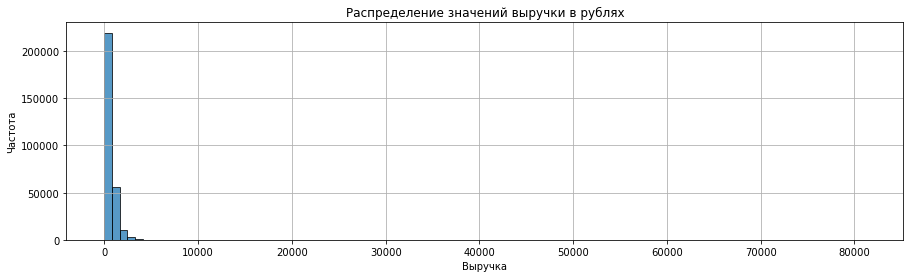

In [19]:
# Строим гистограмму распределения
plt.figure(figsize=(15, 4))

orders_rub_filt['revenue_rub'].plot(
                kind='hist',
                bins=100, 
                alpha=0.75,
                edgecolor='black',
                rot=0, 
)

plt.title('Распределение значений выручки в рублях')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.grid()
plt.show()

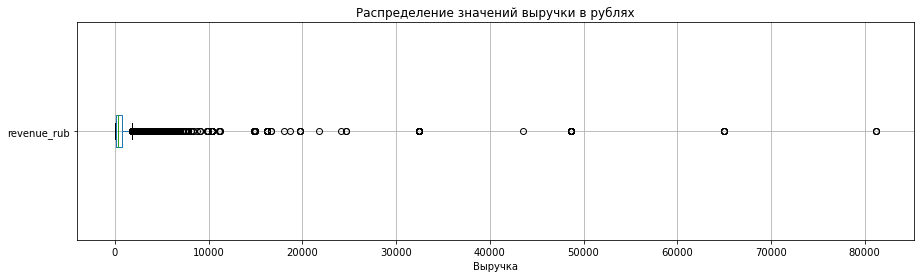

In [20]:
# Строим диаграмму размаха
plt.figure(figsize=(15, 4))
orders_rub_filt.boxplot(column='revenue_rub', vert=False)
plt.title('Распределение значений выручки в рублях')
plt.xlabel('Выручка')
plt.show()

Диаграмма получилась ненаглядной из-за огромного размаха значений и большого количествоа выбросов, во много раз превышающих по размеру типичные значения. Посмотрим на нее, отключив отображение выбросов.

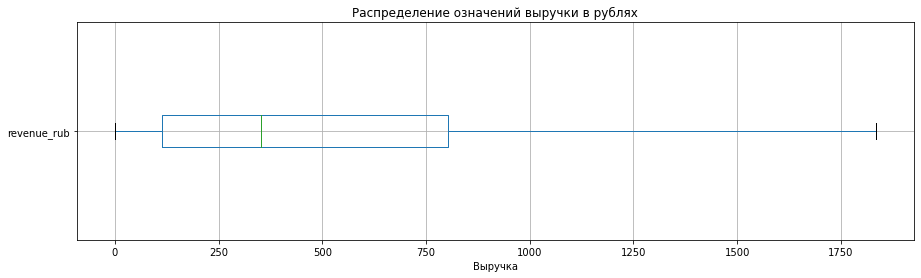

In [21]:
# Строим диаграмму размаха без выбросов
plt.figure(figsize=(15, 4))
orders_rub_filt.boxplot(column='revenue_rub', vert=False, showfliers=False)
plt.title('Распределение означений выручки в рублях')
plt.xlabel('Выручка')
plt.show()

Как мы видим, данные по выручке действительно соджержат множество выбросов. При этом наиболее типичные значения сосредоточены в пределах примерно 115 - 800 руб. Выбросы могут сильно исказить результаты анализа, поэтому ограничем данные по выручке для дальнейшего исследования 99-м процентилем.

In [22]:
#Убираем выбросы, выходящие за пределы 99-го процентиля
orders_rub_filt = orders_rub_filt[(orders_rub_filt['revenue_rub'] <= orders_rub_filt['revenue_rub'].quantile(0.99))]
#Проверяем статистику после фильтрации
orders_rub_filt['revenue_rub'].describe()

count    287643.000000
mean        518.300788
std         511.947892
min           0.000000
25%         112.105000
50%         344.260000
75%         788.660000
max        2628.420000
Name: revenue_rub, dtype: float64

После фильтрации у нас осталось 287643 строки, минимальное значение выручки 0 (возможно это подарочные билеты по промоакции, в реальных условиях возможность такого варианта необходимо уточнить), максимальное - 2628.42 руб., стандартное отклонение уменьшилось, разрыв между медианой и средним значением сократился. Данные стали более реалистичными.

Теперь перейдем к данным столбца 'tickets_count'. Пройдемся по такому же алгоритму.

In [23]:
#Выведем статистические показатели столбца 'revenue_rub'
orders_rub_filt['tickets_count'].describe()

count    287643.000000
mean          2.741252
std           1.162937
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          57.000000
Name: tickets_count, dtype: float64

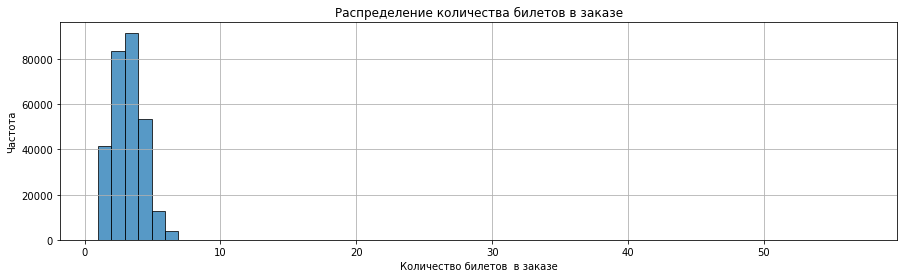

In [24]:
# Строим гистограмму распределения
plt.figure(figsize=(15, 4))

orders_rub_filt['tickets_count'].plot(
                kind='hist',
                bins=57, 
                alpha=0.75,
                edgecolor='black',
                rot=0, 
)

plt.title('Распределение количества билетов в заказе')
plt.xlabel('Количество билетов  в заказе')
plt.ylabel('Частота')
plt.grid()
plt.show()

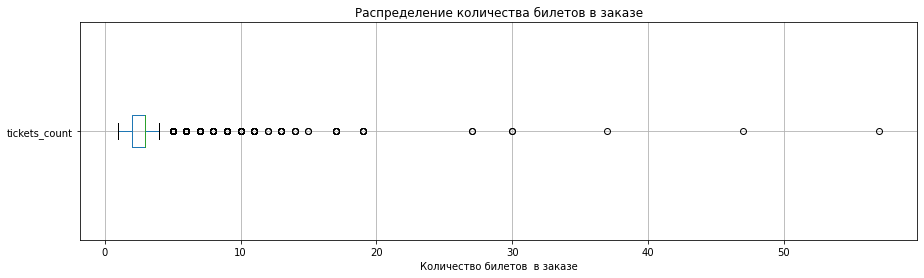

In [25]:
# Строим диаграмму размаха
plt.figure(figsize=(15, 4))
orders_rub_filt.boxplot(column='tickets_count', vert=False)
plt.title('Распределение количества билетов в заказе')
plt.xlabel('Количество билетов  в заказе')
plt.show()

Минимальное значение 1, медиана 3, среднее 2,7, стандартное отклонение 1,2. Большинство значений сосредоточено в диапозоне от 2 до 5. Значения вполне реалистичны.
Диаграмма размаха указывает на наличие выбросов. Однако максимальное значение билетов в 1 заказе - 57 шт. вполне может соответствовать действительности, если речь идет, например, о групповой экскурсии. Поэтому не будем относить выбросы к аномальным значениям и оставим все значения столбца для дальнейшего анализа.

Теперь проверим данные таблиц  на явные и неявные дубликаты.

In [26]:
#Проверяем полные дубликаты:
display(orders_rub_filt.duplicated().sum())
display(events.duplicated().sum())

0

0

Явных дубликатов нет. Поскольку таблица orders_rub_filt содержит числовые данные, необходимые для дальнейших расчетов и анализа, проверим ее неявные дубликаты. Для этого сделаем проверку по основным столбцам, исключая id заказа.

In [27]:
#Проверяем неявные дубликаты по ключевым данным в таблице orders_rub_filt
key_columns = [
     'user_id', 
     'created_ts_msk', 
     'event_id',
     'device_type_canonical',
     'service_name', 
     'tickets_count', 
     'revenue_rub'
    ]

orders_rub_filt.duplicated(subset=key_columns).sum()

40

Обнаружилось 40 дубликатов, посмотрим на них.

In [28]:
dupl_orders = orders_rub_filt[orders_rub_filt.duplicated(subset=key_columns, keep=False)].reset_index(drop=True)
dupl_orders

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,days_since_prev,revenue_rub
0,1123983,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,18,rub,mobile,69.82,Билеты в руки,1,0,69.82
1,1123867,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,18,rub,mobile,69.82,Билеты в руки,1,0,69.82
2,1930705,0dc525d7bacbb0d,2024-07-31,2024-07-31 13:26:11,393430,18,rub,desktop,1556.05,Лови билет!,3,11,1556.05
3,1930763,0dc525d7bacbb0d,2024-07-31,2024-07-31 13:26:11,393430,18,rub,desktop,1556.05,Лови билет!,3,0,1556.05
4,1935113,206ea45ec11d478,2024-10-29,2024-10-29 16:46:54,442183,16,rub,mobile,601.69,Билеты в руки,2,32,601.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,8548012,fd4d47438ebb946,2024-06-19,2024-06-19 15:40:56,489843,18,rub,desktop,1319.43,Билеты без проблем,4,0,1319.43
73,8548041,fd4d47438ebb946,2024-06-19,2024-06-19 15:40:50,489843,18,rub,desktop,989.57,Билеты без проблем,3,0,989.57
74,8548070,fd4d47438ebb946,2024-06-19,2024-06-19 15:40:50,489843,18,rub,desktop,989.57,Билеты без проблем,3,0,989.57
75,8548099,fd4d47438ebb946,2024-06-19,2024-06-19 15:40:56,489843,18,rub,desktop,989.57,Билеты без проблем,3,0,989.57


В данных таблицы обнаружены неявные дубликаты, которые отличатся только id заказа и абсолютно идентичны по другим значениям. Дублирующие записи необходимо удалить.

In [29]:
#удаляем дубликаты по последнему вхождению и делаем проверку
orders_rub_filt = orders_rub_filt.drop_duplicates(subset=key_columns, keep='last').reset_index(drop=True) 
orders_rub_filt.duplicated(subset=key_columns).sum()

0

Добавим в таблицу orders_rub_filt дополнительные столбцы, которые пригодятся нам для дальнейшего анализа:

• 'one_ticket_revenue_rub' с информацией о выручке с продажи одного билета.

• 'month' — с информацией о месяце оформления заказа.

• 'season' — с информацией о сезонности (категории 'лето', 'осень', 'зима', 'весна').

In [30]:
#Для столбца 'one_ticket_revenue_rub' делим выручку с заказа на количество билетов и округляем до 2х знаков
orders_rub_filt['one_ticket_revenue_rub'] = round(orders_rub_filt['revenue_rub']/orders_rub_filt['tickets_count'], 2)
#Для столбца 'month' выделяем номер месяца из столбца 'created_dt_msk'
orders_rub_filt['month'] = orders_rub_filt['created_dt_msk'].dt.month
#Снижаем размерность столбца 'month'
orders_rub_filt['month'] = pd.to_numeric(orders_rub_filt['month'], downcast='integer') 
#Для столбца 'season' применяем функцию cut() к столбцу 'month'
orders_rub_filt['season'] = pd.cut(
    orders_rub_filt['month'], bins=[5, 8, 11], labels=['лето', 'осень']
)

#Делаем проверку
orders_rub_filt.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,days_since_prev,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,16,rub,mobile,1521.94,Край билетов,4,-1,1521.94,380.48,8,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,0,rub,mobile,289.45,Мой билет,2,-1,289.45,144.72,7,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,0,rub,mobile,1258.57,За билетом!,4,75,1258.57,314.64,10,осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,0,rub,mobile,8.49,Лови билет!,2,-1,8.49,4.24,7,лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,18,rub,mobile,1390.41,Билеты без проблем,3,83,1390.41,463.47,10,осень


In [31]:
#Проверяем таблицу
orders_rub_filt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287603 entries, 0 to 287602
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                287603 non-null  int32         
 1   user_id                 287603 non-null  object        
 2   created_dt_msk          287603 non-null  datetime64[ns]
 3   created_ts_msk          287603 non-null  datetime64[ns]
 4   event_id                287603 non-null  int32         
 5   age_limit               287603 non-null  int8          
 6   currency_code           287603 non-null  object        
 7   device_type_canonical   287603 non-null  object        
 8   revenue                 287603 non-null  float64       
 9   service_name            287603 non-null  object        
 10  tickets_count           287603 non-null  int8          
 11  days_since_prev         287603 non-null  int16         
 12  revenue_rub             287603

In [32]:
#Считаем абсолютное количество удаленных после предобработки строк:
drop_row_count = orders.shape[0] - orders_rub_filt.shape[0]
display(drop_row_count)
#Считаем долю удаленных строк:
drop_row_share = round(drop_row_count / orders.shape[0], 3)
display(drop_row_share)

3246

0.011

Объединим таблицы orders_rub_filt и events для проведения исследовательского анализа.

In [33]:
#Объединяем таблицы orders_rub_filt и events по столбцу 'event_id'
afisha_df = pd.merge(
    orders_rub_filt,
    events,
    how="left",
    left_on="event_id", 
    right_on="event_id",
)
#Проверяем
afisha_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287603 entries, 0 to 287602
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                287603 non-null  int32         
 1   user_id                 287603 non-null  object        
 2   created_dt_msk          287603 non-null  datetime64[ns]
 3   created_ts_msk          287603 non-null  datetime64[ns]
 4   event_id                287603 non-null  int32         
 5   age_limit               287603 non-null  int8          
 6   currency_code           287603 non-null  object        
 7   device_type_canonical   287603 non-null  object        
 8   revenue                 287603 non-null  float64       
 9   service_name            287603 non-null  object        
 10  tickets_count           287603 non-null  int8          
 11  days_since_prev         287603 non-null  int16         
 12  revenue_rub             287603

**Промежуточный вывод**

В ходе предобработки мы подготовили данные к исследовательскому анализу.
Были сделаны следующие действия:

- проверены пропуски данных, найденные пропуски в столбце 'days_since_prev' заменены на индикаторы;
- оптимизирован тип данных во всех таблицах;
- основные категориальные данные проверены на ошибки в написании и скрытые пропуски;
- основные количественные данные проверены на выбросы и отфильтрованы;
- удалены дубликаты;
- добавлены новые столбцы, необходимые для дальнейшего исследования;
- объединены данных основных таблиц.

В ходе предобработки мы удалили 3246 строк ( ок. 1,1%) из таблицы order, содержащие аномальные значения и дубликаты.
Добавлены 4 новых столбца:
- 'revenue_rub' - c выручкой, переведенной в рубли,
- 'one_ticket_revenue_rub'-  с информацией о выручке с продажи одного билета в рублях;
- 'month' — с информацией о месяце оформления заказа;
- 'season' — с информацией о сезонности (выделены категории 'лето', 'осень', 'зима', 'весна').  

Итоговая таблица afisha_df, подготовленная для исследовательского анализа, состоит из 26 колонок и 287603 строк.

[*К содержанию*](#intro) 

<a id='3'></a>
## 3. Исследовательский анализ данных

<a id='3.1'></a>
### 3.1. Анализ распределения заказов по сегментам и их сезонные изменения

Изучим изменение пользовательской активности в связи с сезонностью. Проанализируем динамику по таким разрезам:
- тип мероприятия event_type_main;
- тип устройства device_type_canonical;
- категория мероприятий по возрастному рейтингу age_limit.

Сначала посмотрим на динамику заказов по месяцам.

month
6     33974
7     40410
8     44583
9     69336
10    99300
Name: order_id, dtype: int64

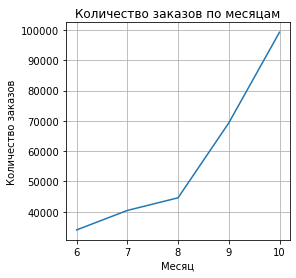

In [34]:
#Рассчитываем количество заказов для каждого месяца
month_count = afisha_df.groupby('month')['order_id'].count()
display(month_count)

# Строим линейный график
month_count.plot(
    kind='line',
    title='Количество заказов по месяцам',
    figsize=(4, 4),
)

plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.grid()
plt.show()

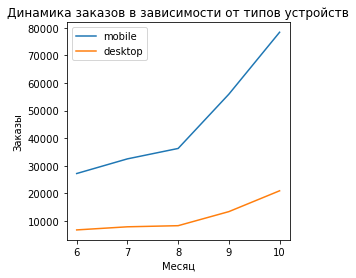

In [35]:
#Посмотрим на динамику в разрезе типов устройств, с которых осуществлялся заказ
month_count_device = afisha_df.groupby(['month', 'device_type_canonical'])['order_id'].count().reset_index()

x = month_count_device.month.unique()
y_m = month_count_device[month_count_device.device_type_canonical=='mobile'].order_id
y_d = month_count_device[month_count_device.device_type_canonical=='desktop'].order_id

plt.figure(figsize=(4, 4))
plt.plot(x, y_m, label ='mobile')
plt.plot(x, y_d,label ='desktop')

plt.xlabel("Месяц")
plt.ylabel("Заказы")
plt.legend()
plt.title('Динамика заказов в зависимости от типов устройств')
plt.show()

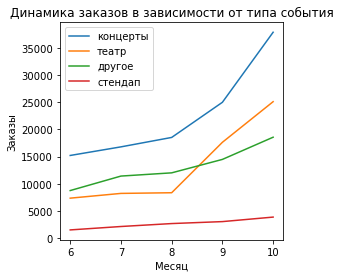

In [36]:
#Посмотрим на динамику в разрезе основных событий (для нагляности возьмем пока самые популярные)
month_count_event = afisha_df.groupby(['month', 'event_type_main'])['order_id'].count().reset_index()

x = month_count_event.month.unique()
y_k = month_count_event[month_count_event.event_type_main=='концерты'].order_id
y_t = month_count_event[month_count_event.event_type_main=='театр'].order_id
y_d = month_count_event[month_count_event.event_type_main=='другое'].order_id
y_s = month_count_event[month_count_event.event_type_main=='стендап'].order_id

plt.figure(figsize=(4, 4))
plt.plot(x, y_k, label ='концерты')
plt.plot(x, y_t,label ='театр')
plt.plot(x, y_d, label ='другое')
plt.plot(x, y_s,label ='стендап')

plt.xlabel("Месяц")
plt.ylabel("Заказы")
plt.legend()
plt.title('Динамика заказов в зависимости от типа события')
plt.show()

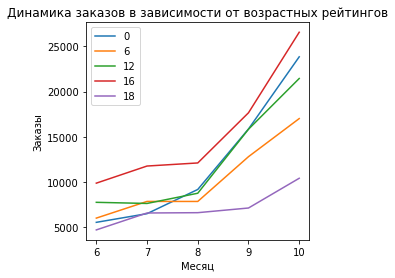

In [37]:
#Посмотрим на динамику в разрезе возрастных рейтингов
month_count_age = afisha_df.groupby(['month', 'age_limit'])['order_id'].count().reset_index()

x = month_count_age.month.unique()
y_0 = month_count_age[month_count_age.age_limit==0].order_id
y_6 = month_count_age[month_count_age.age_limit==6].order_id
y_12 = month_count_age[month_count_age.age_limit==12].order_id
y_16 = month_count_age[month_count_age.age_limit==16].order_id
y_18 = month_count_age[month_count_age.age_limit==18].order_id

plt.figure(figsize=(4, 4))
plt.plot(x, y_0, label ='0')
plt.plot(x, y_6,label ='6')
plt.plot(x, y_12, label ='12')
plt.plot(x, y_16,label ='16')
plt.plot(x, y_18,label ='18')

plt.xlabel("Месяц")
plt.ylabel("Заказы")
plt.legend()
plt.title('Динамика заказов в зависимости от возрастных рейтингов')
plt.show()

Начнем с детализации по типам устройств. Построим столбчатую диаграмму для абсолютных значений и для долей.

,осень,лето
device_type_canonical,,
desktop,34349,22993
mobile,134287,95974


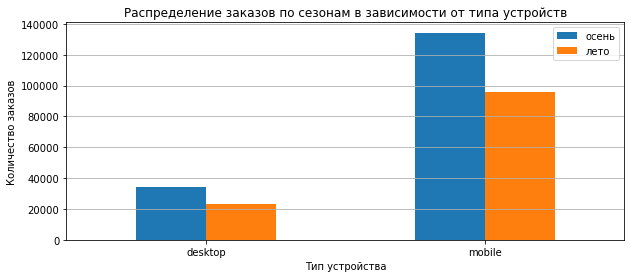

In [38]:
# Построим график столбчатой диаграммы
season_orders_device = afisha_df.groupby('device_type_canonical')['season'].value_counts().unstack(fill_value=0)
display(season_orders_device)

season_orders_device.plot(kind='bar',
               title=f'Распределение заказов по сезонам в зависимости от типа устройств',
               legend=True,
               ylabel='Количество заказов',
               xlabel='Тип устройства',
               rot=0,
               figsize=(10, 4))
plt.grid(axis='y')

plt.show()

,осень,лето
device_type_canonical,,
desktop,0.599020,0.400980
mobile,0.583195,0.416805


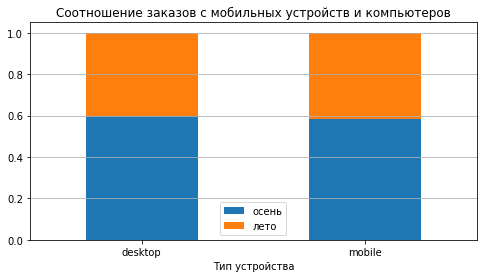

In [39]:
#Построим график отображающий соотношение долей осенних и летних заказов
season_device_sh = afisha_df.groupby('device_type_canonical')['season'].value_counts(normalize=True).unstack(fill_value=0)
display(season_device_sh)

season_device_sh.plot(kind='bar',
               title=f'Соотношение заказов с мобильных устройств и компьютеров',
               legend=True,
               stacked=True,          
               xlabel='Тип устройства',
               rot=0,
               figsize=(8, 4))


plt.grid(axis='y')

plt.show()

Как видно по графикам доля заказов с мобильных устройств практически одинакова для летнего и осенннего сезона.

Теперь рассмотрим детализации по типам событий. 

,лето,осень
event_type_main,,
выставки,2407,2402
другое,32206,33071
концерты,50556,62900
спорт,3003,18862
стендап,6348,6924
театр,23958,42760
ёлки,273,1695


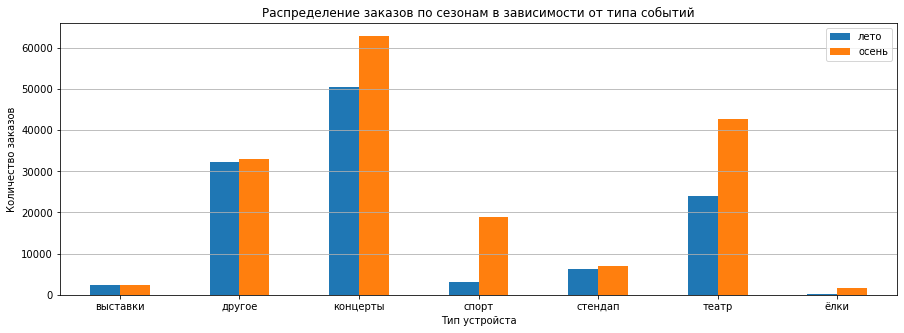

In [40]:
# Построим график столбчатой диаграммы
season_orders_event = afisha_df.groupby('event_type_main')['season'].value_counts().unstack(fill_value=0)
display(season_orders_event)

season_orders_event.plot(kind='bar',
               title=f'Распределение заказов по сезонам в зависимости от типа событий',
               legend=True,
               ylabel='Количество заказов',
               xlabel='Тип устройста',
               rot=0,
               figsize=(15, 5))
plt.grid(axis='y')

plt.show()

,лето,осень
event_type_main,,
выставки,0.500520,0.499480
другое,0.493374,0.506626
концерты,0.445600,0.554400
спорт,0.137343,0.862657
стендап,0.478300,0.521700
театр,0.359093,0.640907
ёлки,0.138720,0.861280


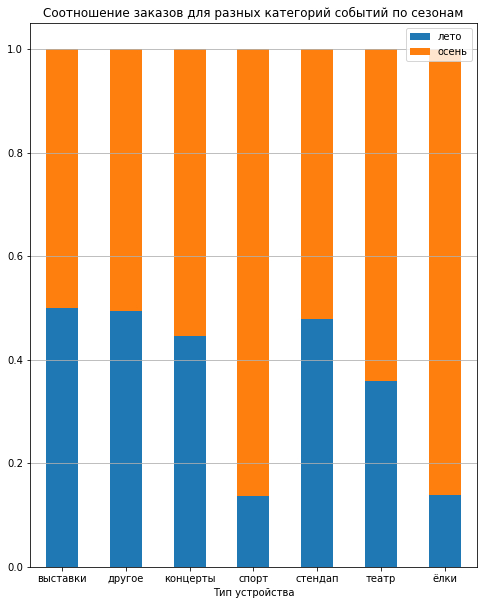

In [41]:
#Построим график отображающий соотношение долей осенних и летних заказов
season_event_sh = afisha_df.groupby('event_type_main')['season'].value_counts(normalize=True).unstack(fill_value=0)
display(season_event_sh)

season_event_sh.plot(kind='bar',
               title=f'Соотношение заказов для разных категорий событий по сезонам',
               legend=True,
               stacked=True,          
               xlabel='Тип устройства',
               rot=0,
               figsize=(8, 10))

plt.grid(axis='y')

# Выводим график
plt.show()

По графику видно, что доля продаж на спортивные мероприятия и ёлки увеличивается в несколько раз в осенний сезон. Для ёлок такой рост абсолютно закономерен, потому что сами мероприятия проводятся в декабре-январе. Рост продаж на спортивные мероприятия скорее всего обусловлен крупными спортивными событиями, проводящимися в конце года. Немного растет доля продаж в театры, а вот по остальным событиям доли продаж сокращаются, причем самое заметное сокращение доли продаж у категории другое. При этом мы помним, что абсолютный рост заказов наблюдается по всем без исключения категориям.

Рассмотрим детализацию по возрастному рейтингу.

,лето,осень
age_limit,,
0,21272,39713
6,21767,29836
12,24194,37295
16,33789,44219
18,17945,17573


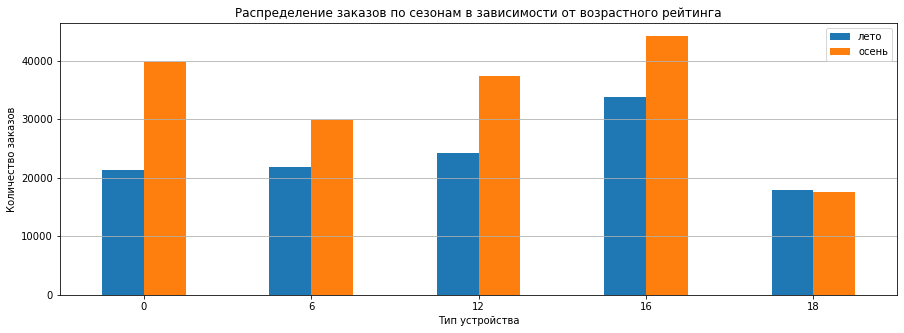

In [42]:
# Построим график столбчатой диаграммы
season_orders_age = afisha_df.groupby('age_limit')['season'].value_counts().unstack(fill_value=0)
display(season_orders_age)

season_orders_age.plot(kind='bar',
               title=f'Распределение заказов по сезонам в зависимости от возрастного рейтинга',
               legend=True,
               ylabel='Количество заказов',
               xlabel='Тип устройства',
               rot=0,
               figsize=(15, 5))
plt.grid(axis='y')

plt.show()

,лето,осень
age_limit,,
0,0.348807,0.651193
6,0.421817,0.578183
12,0.393469,0.606531
16,0.433148,0.566852
18,0.505237,0.494763


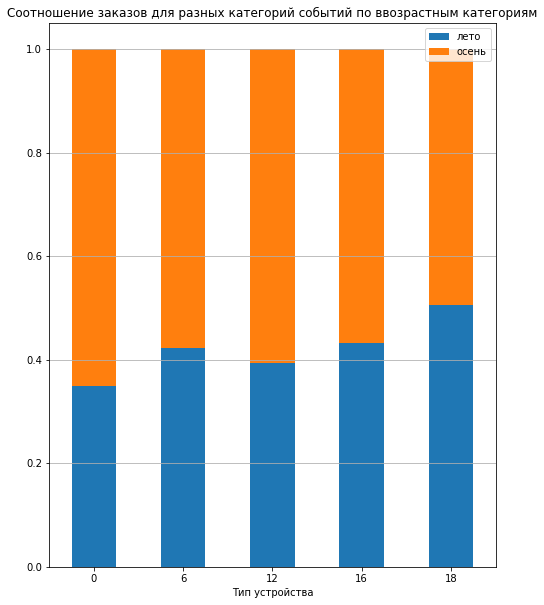

In [43]:
#Построим график отображающий соотношение долей осенних и летних заказов
season_age_sh = afisha_df.groupby('age_limit')['season'].value_counts(normalize=True).unstack(fill_value=0)
display(season_age_sh)

season_age_sh.plot(kind='bar',
               title=f'Соотношение заказов для разных категорий событий по ввозрастным категориям',
               legend=True,
               stacked=True,          
               xlabel='Тип устройства',
               rot=0,
               figsize=(8, 10))

plt.grid(axis='y')

plt.show()

По графикам можно отметить, что в категории 18+ в единственной из всех рассматриваемых наблюдается совсем небольшое снижение продаж, однако, учитывая, что в категорию "осень" вошло только 2 месяца, а в лето 3, то тенденция на увеличение продаж осенью характерна и для этой категории. По соотношениям категорий мы видим, что увеличивается доля детских  (0-12) и снижается доля "взрослых" (16-18) мероприятий. Видимо это связано с продажей билетов на тематические новогодние мерроприятия, в первую очередь "ёлки", которые более актуальны для детей.

Теперь посмотрим на изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью. 

In [44]:
#Создадим сводную таблицу для категорий событий и сезона и средним значением выручки с билета
season_cost_events = pd.pivot_table(
    afisha_df,
    columns='season',
    index='event_type_main',
    values=['one_ticket_revenue_rub'],
    aggfunc='mean'
).reset_index()

season_cost_events.columns

MultiIndex([(       'event_type_main',      ''),
            ('one_ticket_revenue_rub',  'лето'),
            ('one_ticket_revenue_rub', 'осень')],
           names=[None, 'season'])

In [45]:
#Переименуем столбцы
col_names = ['event_type_main', 'cost_sum', 'cost_aut']
season_cost_events.columns = col_names

#Найдём относительное изменение осенних значений по сравнению с летними
season_cost_events['relative_change'] = round(season_cost_events['cost_aut']/season_cost_events['cost_sum'], 2)
season_cost_events = season_cost_events.set_index('event_type_main')
season_cost_events

,cost_sum,cost_aut,relative_change
event_type_main,,,
выставки,86.743806,91.904871,1.06
другое,77.829812,76.475579,0.98
концерты,302.342806,269.316353,0.89
спорт,50.813776,50.021515,0.98
стендап,218.585918,231.466943,1.06
театр,214.398950,176.239014,0.82
ёлки,271.435421,230.309174,0.85


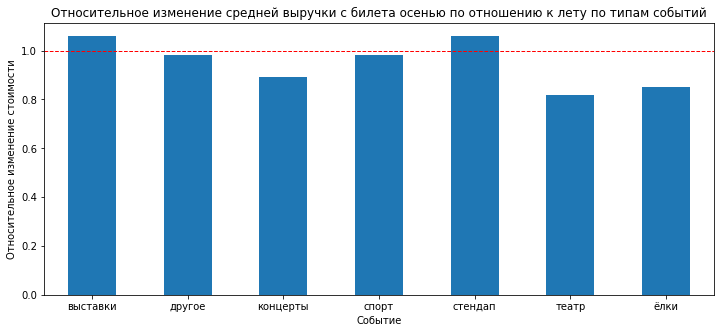

In [46]:
#Создадим визуализацию, отображающую относительное изменение выручки с 1 билета по категориям мероприятий
season_cost_events['relative_change'].plot(kind='bar',
               title= 'Относительное изменение средней выручки с билета осенью по отношению к лету по типам событий',
               legend=False,
               ylabel='Относительное изменение стоимости',
               xlabel='Событие',
               rot=0,
               figsize=(12, 5))

# Наносим на график линию со значением 1, которое будет означать отсутствие изменений:
plt.axhline(1, 
            color='red', 
            linestyle='--', 
            linewidth=1, 
            label='Отсутствие изменений')

plt.grid(axis='y')

plt.grid(axis='y')

# Выводим график
plt.show()

Итак, мы видим, что билеты подорожали только на выставки и стендапы, при этом продажи по этим мероприятиям были относительно стабильны и не показывали такого большого роста осенью по отношению к лету, как другие мероприятия. Возможно повышение стоимости билетов сыграло в этом свою роль.

Выручка с 1 билета (а значит и стоимость билета) на спортивные мероприятия, а также на категорию "другое" стабильна.

А вот концерты, театры и ёлки показали снижение средней выручки с 1 билета. Это может быть связано как с акционными предновогодними продажами и скидками на билеты, либо с тем, что в первую очередь (летом) были выкулены самые дорогие билеты с лучшими местами на наиболее масштабные и значимые мероприятия, проводимые в конце года.

**Промежуточные выводы:**
- осенью наблюдается рост продаж билетов по всем категориям в разрезе типа устройств, с которых осуществляется покупка, типа мероприятий, а также возрастных рейтингов, но темпы роста в разных каегориях различаются;
- тип устройства не влияет на соотношение заказов;
- осенью меняется соотношение продаж на разные типы мероприятий: увеличивется доля продаж на ёлки,спортивные мероприятия  и театры и снижается на концерты, стендапы, выставки и в наибольшей степени на категорию "другое";
- осенью увеличивается доля продаж  детских (0-12 лет) и снижается доля "взрослых" (16-18 лет ) мероприятий;
- средняя стоимость билетов на различные мероприятия тоже меняется с наступлением осени, билеты на стендапы и выставки  приносят больше выручки с продажи 1 билета, выручка за 1 билет  на спортивные мероприятия и "другое" стабильна, на остальные мероприятия снижается.

### 3.2. Осенняя активность пользователей

Изучим активность пользователей осенью 2024 года. Отфильруем нашу таблицу по сезону "осень".

In [47]:
#Фильруем данные по осенним месяцам
afisha_autumn = afisha_df[afisha_df['season'] == 'осень'].copy()

Создадим сводную таблицу с основными показателями за каждый день.

In [48]:
#Создадим сводную таблицу с числом заказов, количеством активных пользователй  и средней выручкой с  одного билета
daily_afisha_autumn = afisha_autumn.pivot_table(
    index='created_dt_msk',
    aggfunc={'order_id': 'count', 'user_id': 'nunique', 'one_ticket_revenue_rub': 'mean'},
)
daily_afisha_autumn

,one_ticket_revenue_rub,order_id,user_id
created_dt_msk,,,
2024-09-01,201.678355,1331,565
2024-09-02,190.015741,1376,573
2024-09-03,80.802805,5095,777
2024-09-04,179.528138,1762,684
2024-09-05,190.040566,1942,739
...,...,...,...
2024-10-27,187.948129,2848,1034
2024-10-28,171.174827,2840,985
2024-10-29,178.543743,2837,999


In [49]:
#Даем колонкам понятные названия
daily_col_name = ['one_ticket_revenue_rub', 'ordes', 'dau']
daily_afisha_autumn.columns = daily_col_name

#Рассчитываем среднее число заказов на одного пользователя
daily_afisha_autumn['orders_per_user'] = round(daily_afisha_autumn['ordes'] / daily_afisha_autumn['dau'], 1)

daily_afisha_autumn

,one_ticket_revenue_rub,ordes,dau,orders_per_user
created_dt_msk,,,,
2024-09-01,201.678355,1331,565,2.4
2024-09-02,190.015741,1376,573,2.4
2024-09-03,80.802805,5095,777,6.6
2024-09-04,179.528138,1762,684,2.6
2024-09-05,190.040566,1942,739,2.6
...,...,...,...,...
2024-10-27,187.948129,2848,1034,2.8
2024-10-28,171.174827,2840,985,2.9
2024-10-29,178.543743,2837,999,2.8


Визуализируем полученные данные

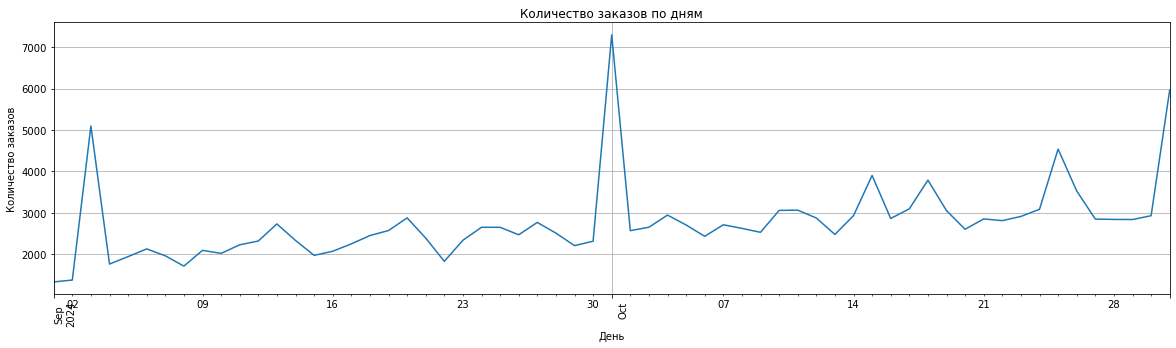

In [50]:
# Строим линейный график для ежедневных заказов
daily_afisha_autumn['ordes'].plot(
    kind='line',
    title='Количество заказов по дням',
    figsize=(20, 5),
)

plt.xlabel('День')
plt.ylabel('Количество заказов')
plt.xticks(rotation=90)
plt.grid()
plt.show()

По графику наблюдаются несколько явных всплесков в продажаха нчале сентября, в начале октября и и в последний день октября.
Это информация для дополнительно изучения. Возможно в начале месяца проводятся акции или открываются продажи билетов на мероприятия. 

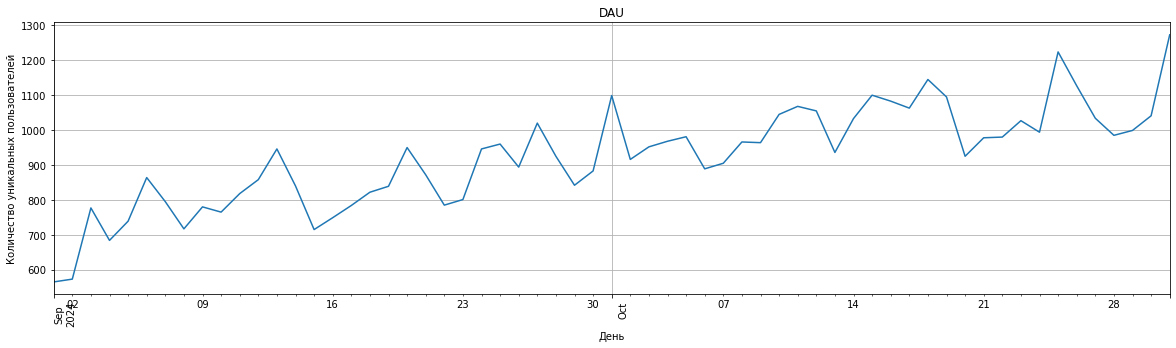

In [51]:
# Строим линейный график для количества активных пользователей DAU
daily_afisha_autumn['dau'].plot(
    kind='line',
    title='DAU',
    figsize=(20, 5),
)

plt.xlabel('День')
plt.ylabel('Количество уникальных пользователей')
plt.xticks(rotation=90)
plt.grid()
plt.show()

Количество уникальных пользователей нестабильно, но в целом мы наблюдаем их рост на протяжении 2х месяцев. Это Хороший показатель для бизнеса.

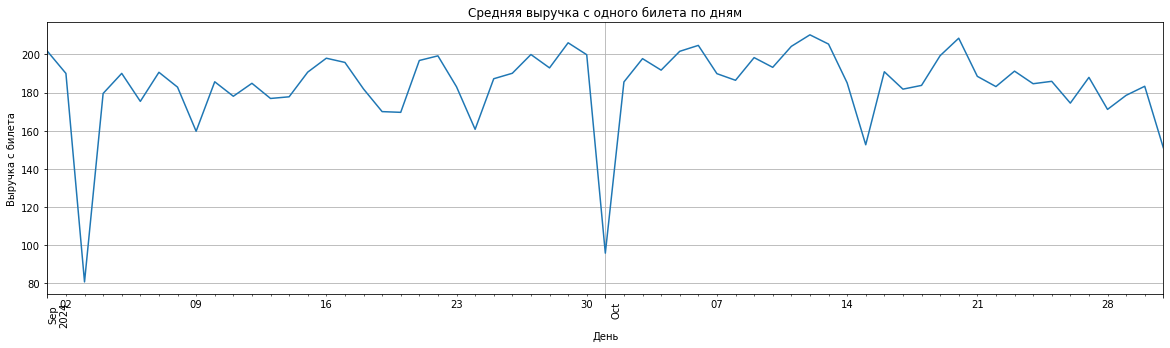

In [52]:
# Строим линейный график для средней выручки с одного билета
daily_afisha_autumn['one_ticket_revenue_rub'].plot(
    kind='line',
    title='Средняя выручка с одного билета по дням',
    figsize=(20, 5),
)

plt.xlabel('День')
plt.ylabel('Выручка с билета')
plt.xticks(rotation=90)
plt.grid()
plt.show()

На данном графике мы тоже наблюдаем аномалию в те же дни. Средняя выручка с одного билета билета по дням обычно колеблется от 160  до 200 руб. Однако в начале кажого месяца она резко падает.

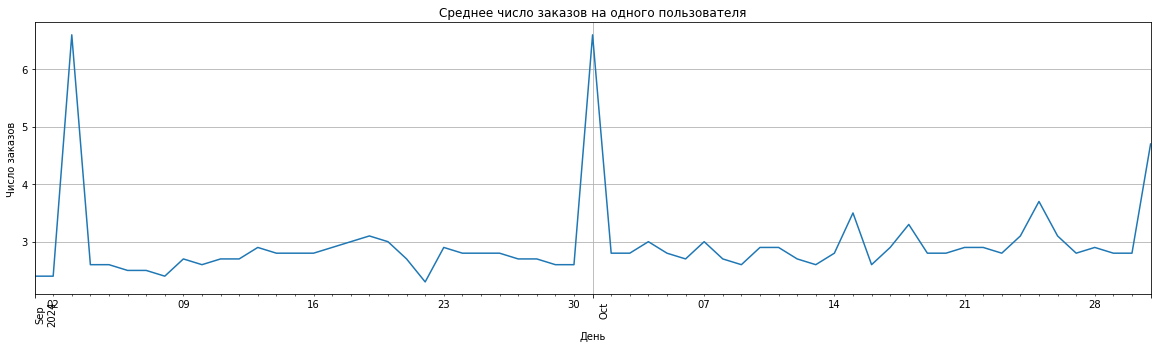

In [53]:
# Строим линейный график для среднего числа заказов на одного пользователя
daily_afisha_autumn['orders_per_user'].plot(
    kind='line',
    title='Среднее число заказов на одного пользователя',
    figsize=(20, 5),
)

plt.xlabel('День')
plt.ylabel('Число заказов')
plt.xticks(rotation=90)
plt.grid()
plt.show()

На данном графике мы тоже наблюдаем всплески в начале каждого месяцы по числу заказов, в эти дни их более 6, что в реальной жизни маловероятно. Найдем медиану по количеству заказов на 1 пользователя за весь период, чтобы картина стала яснее.

In [54]:
#Найдем медиану по количеству зхаказов на одного пользователя в день
afisha_autumn.groupby(['user_id', 'created_dt_msk'])['order_id'].count().median()

1.0

Чаще всего пользователи делают не более одного заказа в день, однако мы наблюдаем, что средние значения по дневным заказам на пользователя выше, а в начале каждого месяца повышаются выше 6. 

3 сентября и 1 октября явно просматриваются аномалии в продаже билетов. Рассмотрим один из этих дней более детально.

In [55]:
#Сгруппируем данные за 1 октября 2024 по уникальным пользователям
afisha_autumn[afisha_autumn['created_dt_msk'] == '2024-10-01'].groupby('user_id').agg(
    {
        'order_id': 'count',
        'event_id': 'nunique',
        'city_id': 'nunique',
        'event_type_main': 'nunique',
        'service_name': 'nunique',
        'tickets_count': 'sum',
        'one_ticket_revenue_rub': 'mean',
    }
).sort_values('order_id', ascending=False)


,order_id,event_id,city_id,event_type_main,service_name,tickets_count,one_ticket_revenue_rub
user_id,,,,,,,
cdbc02c6ad8087a,242,25,9,4,13,702.0,52.159174
0beb8fc0c0a9ce1,163,63,30,5,15,439.0,96.466258
18e9aead0a393e7,130,41,16,4,11,403.0,83.952538
8d52f5c8c871f39,127,10,7,3,8,404.0,73.495354
d4ed68b25980202,116,19,1,1,1,334.0,28.898103
...,...,...,...,...,...,...,...
6c514578b4707b2,1,1,1,1,1,3.0,11.250000
6c94dea24d07f78,1,1,1,1,1,2.0,422.360000
6cc010ca09abfff,1,1,1,1,1,4.0,339.310000


мы видим, что часть пользователей сделала в этот день очень большое число заказов в разных городах, на разные мероприятия, используя разные сервисы, при этом их средняя стоимость ниже типичной. Посмотрим более детально на заказы пользователя, сделавшего максимальное количество заказов.

In [56]:
afisha_autumn[(afisha_autumn['user_id'] == 'cdbc02c6ad8087a')
    & (afisha_autumn['created_dt_msk'] == '2024-10-01')].groupby('event_id').agg(
    {'order_id': 'count', 'tickets_count': 'sum', 'one_ticket_revenue_rub': 'mean'}
).sort_values('order_id', ascending=False)

,order_id,tickets_count,one_ticket_revenue_rub
event_id,,,
574431,72,211.0,38.996528
574450,68,199.0,17.950000
574441,32,100.0,30.610000
574410,22,64.0,30.170000
574407,16,53.0,21.120000
378923,6,12.0,112.760000
506552,3,7.0,337.120000
533558,3,4.0,360.440000
577952,3,11.0,10.930000


Посмотрим на событие с максимальным количеством заказов

In [57]:
afisha_autumn[
    (afisha_autumn['user_id'] == 'cdbc02c6ad8087a')
    & (afisha_autumn['created_dt_msk'] == '2024-10-01')
    & (afisha_autumn['event_id'] == 574431)
][[
    'created_ts_msk',
    'service_name',
    'device_type_canonical',
    'tickets_count',
    'days_since_prev',
    'one_ticket_revenue_rub',
    'event_type_main',
    'venue_name'
]].sort_values('created_ts_msk')

,created_ts_msk,service_name,device_type_canonical,tickets_count,days_since_prev,one_ticket_revenue_rub,event_type_main,venue_name
238696,2024-10-01 11:11:16,Билеты в руки,desktop,2,0,38.99,спорт,"Студия дизайна ""Платформа"" Инкорпорэйтед"
238606,2024-10-01 11:11:20,Билеты в руки,desktop,5,0,39.00,спорт,"Студия дизайна ""Платформа"" Инкорпорэйтед"
238617,2024-10-01 11:11:43,Билеты в руки,desktop,4,0,39.00,спорт,"Студия дизайна ""Платформа"" Инкорпорэйтед"
238782,2024-10-01 11:12:05,Билеты в руки,mobile,3,0,39.00,спорт,"Студия дизайна ""Платформа"" Инкорпорэйтед"
238745,2024-10-01 11:12:44,Билеты в руки,desktop,2,0,38.99,спорт,"Студия дизайна ""Платформа"" Инкорпорэйтед"
...,...,...,...,...,...,...,...,...
238685,2024-10-01 12:14:28,Билеты в руки,mobile,1,0,39.00,спорт,"Студия дизайна ""Платформа"" Инкорпорэйтед"
238748,2024-10-01 12:14:51,Билеты в руки,mobile,2,0,38.99,спорт,"Студия дизайна ""Платформа"" Инкорпорэйтед"
238727,2024-10-01 12:15:12,Билеты в руки,mobile,1,0,39.00,спорт,"Студия дизайна ""Платформа"" Инкорпорэйтед"
238776,2024-10-01 12:15:50,Билеты в руки,desktop,4,0,39.00,спорт,"Студия дизайна ""Платформа"" Инкорпорэйтед"


Заказы на одно и то же мероприятие были сделаны 72 раза с разных устройств в течение часа, количество билетов в заказах разное, стоимость одинаковая. но ниже средней. Возмоно мы имеем дело со сбоем в системе, либо посредническим сервисом, через который скупаются билеты по низкой цене и потом перепродаются. Этот вопрос следует изучить более подробно, чтоб понять откуда берутся такие аномальные закупки и понять как они влияют на выручку сервиса в целом.

Посмотрим есть ли цикличность в продаже билетов в течение недели. Выделим день недели из дат и сравним пользовательскую
активность в будни и выходные.

In [58]:
#Выделяем день недели из даты в отдельный столбец 'dow'
afisha_autumn['dow'] = afisha_autumn['created_dt_msk'].dt.weekday
#Сгруппируем данные по дням недели и посмотрим на показатели DAU и количество заказов.
pivot_dow = afisha_autumn.pivot_table( index='dow', aggfunc={'user_id': 'nunique', 'order_id': 'count'})
pivot_dow


,order_id,user_id
dow,,
0,21521,4450
1,31482,4797
2,22887,4818
3,27149,4968
4,24837,4871
5,21351,4570
6,19409,4397


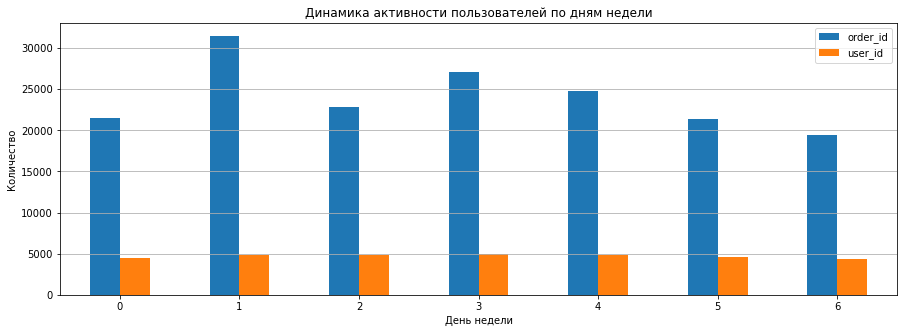

In [60]:
# Построим график столбчатой диаграммы

pivot_dow.plot(kind='bar',
               title=f'Динамика активности пользователей по дням недели',
               legend=True,
               ylabel='Количество',
               xlabel='День недели',
               rot=0,
               figsize=(15, 5))
plt.grid(axis='y')

plt.show()

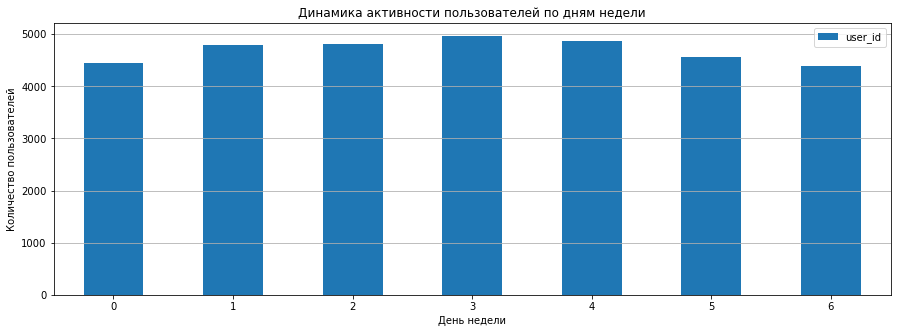

In [61]:
# Построим график столбчатой диаграммы отдельно для DOW для большей наглядности

pivot_dow['user_id'].plot(kind='bar',
               title=f'Динамика активности пользователей по дням недели',
               legend=True,
               ylabel='Количество пользователей',
               xlabel='День недели',
               rot=0,
               figsize=(15, 5))
plt.grid(axis='y')

plt.show()

Как видно по графику в выходные и понедельник активность пользователей минимальна, видимо это связано с тем,  что большинство мероприятий проходит в выходные, а билеты как правило покупаются заранее, а не в день мероприятия.  В целом динамика количества уникальных пользователей по дням недели повторяет динамику заказов, за исключением  вторника и среды. Возможно на это повлияли аномальные дни, которые были рассмотрены выше. 3 сентября и 1 октября 2024, когда один пользователь делал аномально большое количество заказов по низкой цене, приходятся на вторник.

**Промежуточные выводы:**
- показатели DAU и количество заказов колеблятся в разные дни, но в целом наблюдается тенденция к росту, что является хорошим показателем для бизнеса;
- показатели количество заказов, среднее количество показателей на одного клиента и средняя выручка с 1 заказа имеют атипичные всплески 3 сентября и 1 октября, когда на 1 пользователя приходится аномально большое количество заказов в день на разные мероприятия и в разных городах по низкой цене;
- среднее количество заказов на одного пользователя колеблется в районе 3, при этом медиана по этому показателю за весь осенний сезон равна 1, т.е. чаще всего пользователи делают не более одного заказа, но в данных присутствуют пользователи, которые делают много заказов за день и это влияет на средний показатель. Возможно это организации-перекупщики или сбой в записи данных;
- наибольшая активность пользователей наблюдается в будние дни, в выходные и понедельник - минимальная.


### 3.3. Популярные события и партнёры

Посмотрим, как события распределены по регионам и партнёрам. Выделим ключевые регионы и партнёров, которые вносят наибольший вклад в выручку.
Сгруппируем данные по регионам и выделим для каждого уникальное количество мероприятий и общее число заказов.

In [62]:
# Создадим сводную таблицу с количеством уникальных мероприятий и количеством заказов по регионам
afisha_df_regions = afisha_df.pivot_table(
    index='region_name',
    aggfunc={'event_name': 'nunique', 'event_type_main': 'nunique', 'order_id': 'count'},
)
#Отсортируем регионы по количеству заказов и посмотрим на ТОП-10
afisha_df_regions.sort_values('order_id', ascending=False).head(10)

,event_name,event_type_main,order_id
region_name,,,
Каменевский регион,4751,7,89746
Североярская область,3194,7,43737
Широковская область,986,7,16102
Медовская область,484,7,13892
Озернинский край,307,7,10405
Светополянский округ,990,7,7486
Малиновоярский округ,164,6,6509
Речиновская область,652,7,6266
Солнечноземская область,468,7,6243


Практически во всех топ-10 регионов проводится все многообразие мероприятий. Лидером и по количеству заказов и по разнообразию событий является Каменевский регион, второе место и Североярской области. Другие регионы проводят значительно меньше мероприятий и соответсвенно имеют меньшее количество заказов. Визуалирируем топ-10 регионов по двум показателям и рассчитаем по ним общую статистику.

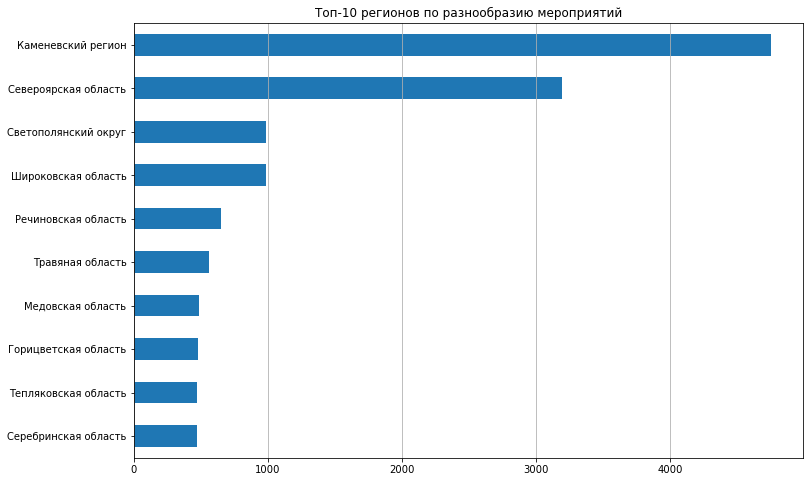

count      81.000000
mean      235.962963
std       643.246637
min         2.000000
25%        17.000000
50%        68.000000
75%       152.000000
max      4751.000000
Name: event_name, dtype: float64

In [63]:
#Выведем линейчатую диаграмму с топом 10 регионов по разнообразию мероприятий для наглядности:
top_10_events = afisha_df.groupby('region_name')['event_name'].nunique().sort_values(ascending=False).head(10)
top_10_events = top_10_events.sort_values()
top_10_events.plot(kind='barh',
               title= 'Топ-10 регионов по разнообразию мероприятий',
               legend=False,
               ylabel='Количество уникальных мероприятий',
               xlabel='',
               rot=0,
               figsize=(12, 8))
plt.grid(axis='x')
plt.show()

#Посмотрим также на общую статистику уникальных мероприятий по регионам
afisha_df.groupby('region_name')['event_name'].nunique().describe()

Как мы видим, разброс количества мероприятий по регионам очень большой, в самых маленьких из них всего по 2 мероприятия, среднее количество 236 мероприятий, медиана всего 68. На такой перекос повлияли в первую очередь 2 лидера Каменевский регион и Североярская область.

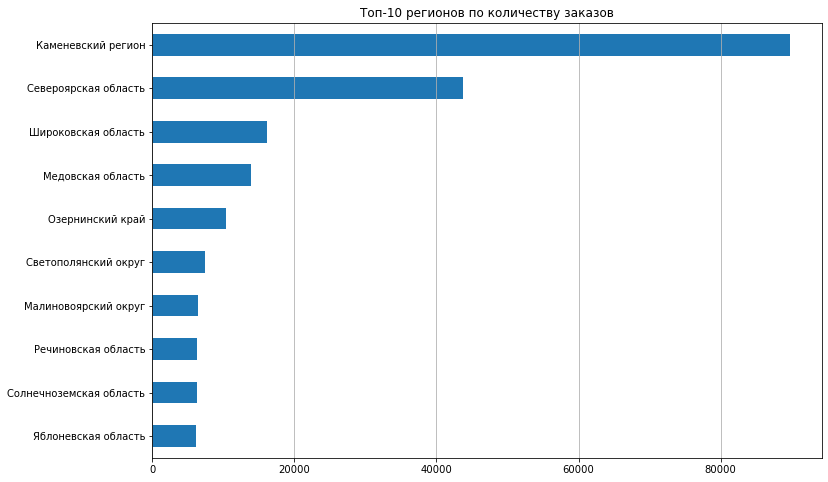

count       81.000000
mean      3547.716049
std      11151.515877
min          7.000000
25%        264.000000
50%        810.000000
75%       2553.000000
max      89746.000000
Name: order_id, dtype: float64

In [64]:
#Выведем линейчатую диаграмму с топом 10 регионов по количеству заказов:
top_10_orders = afisha_df.groupby('region_name')['order_id'].count().sort_values(ascending=False).head(10)
top_10_orders = top_10_orders.sort_values()
top_10_orders.plot(kind='barh',
               title= 'Топ-10 регионов по количеству заказов',
               legend=False,
               ylabel='Количество заказов',
               xlabel='',
               rot=0,
               figsize=(12, 8))
plt.grid(axis='x')
plt.show()

#Смотрим общую статистику количества заказов по регионам
afisha_df.groupby('region_name')['order_id'].count().describe()

По количеству заказов похожая картина: минимальное значение заказов 7, максимальное почти 90 тыс., из-за этого очень большое стандартное отклонение и разница между средним значением и медианой, которые равны соответственно 3548 и 810 заказам.

 Посмотрим на эти показатели в долевом выражении.

In [65]:
#Нормализуем данные
afisha_df_regions_normalized = afisha_df_regions.div(afisha_df_regions.sum(axis=0), axis=1)
afisha_df_regions_normalized[['event_name','order_id']].sort_values('order_id', ascending=False).head(10)

,event_name,order_id
region_name,,
Каменевский регион,0.248574,0.312307
Североярская область,0.167111,0.152200
Широковская область,0.051588,0.056033
Медовская область,0.025323,0.048343
Озернинский край,0.016062,0.036208
Светополянский округ,0.051797,0.026050
Малиновоярский округ,0.008581,0.022651
Речиновская область,0.034113,0.021805
Солнечноземская область,0.024486,0.021725


На Каменевский регион приходится более 30% всех заказов, оформленных через сервис Яндекс афиша, и четверть проводимых мероприятий. На Североярскую облась приходится 15% заказов и 17% событий. Для других областей эти показатели не превышают 6%. Обращает на себя внимание Малиновоярский округ, где количество заказов 2,2%, а количество меоприятий менее 1%. Возможно это говорит о проведении масштабных мероприятий по типу крупных спортивных событий или фестивалей, на которые приходится большое количество заказов.

Теперь посмотрим на общее число уникальных мероприятий, заказов и суммарную выручку для каждого билетного партнёра.

In [66]:
# Создадим сводную таблицу  по билетным партнерам
afisha_df_service = afisha_df.pivot_table(
    index='service_name',
    aggfunc={'event_name': 'nunique', 'order_id': 'count', 'revenue_rub': 'sum'},
)
#Отсортируем партнеров по суммарной выручке и посмотрим на ТОП-15
afisha_df_service.sort_values('revenue_rub', ascending=False).head(15)

,event_name,order_id,revenue_rub
service_name,,,
Билеты без проблем,3132,63026,24854263.36
Мой билет,1031,34142,21062014.50
Облачко,1762,26410,18609295.34
Лови билет!,3851,40787,16728569.91
Весь в билетах,688,16437,16565996.38
Билеты в руки,2932,40210,13204577.44
Край билетов,233,6118,6429181.51
Прачечная,874,10222,4746810.52
Дом культуры,231,4428,4400412.61


Лови билет!	Среди билетных операторов есть явный лидер, который имеет самые высокие покатели по заказм и суммарной выручке - это "Билеты без проблем". А по разнообразию мероприятий лидирует "Лови билет!". У большинства партнеров показатели числа уникальных мероприятий, заказов и суммарной выручки находятся на разных позициях. Визуализируем топ-10 по каждому показателю и рассчитаем по ним статистику.

count      36.000000
mean      550.055556
std       953.085484
min         1.000000
25%        14.250000
50%       162.000000
75%       631.000000
max      3851.000000
Name: event_name, dtype: float64

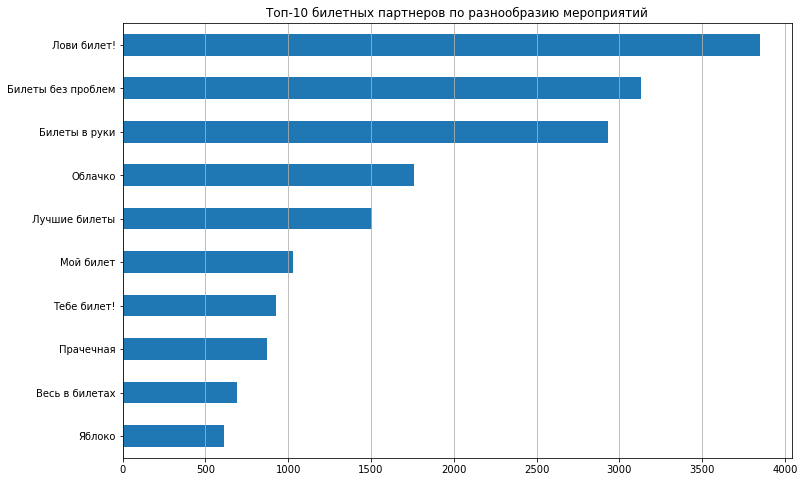

In [67]:
#Посмотрим также на общую статистику уникальных мероприятий по партнерам
events_service = afisha_df.groupby('service_name')['event_name'].nunique()
display(events_service.describe())

#Выведем линейчатую диаграмму с топом 10 партнеров по разнообразию мероприятий
top_10_events_service = events_service.sort_values(ascending=False).head(10)
top_10_events_service = top_10_events_service.sort_values()
top_10_events_service.plot(kind='barh',
               title= 'Топ-10 билетных партнеров по разнообразию мероприятий',
               legend=False,
               ylabel='Количество уникальных мероприятий',
               xlabel='',
               rot=0,
               figsize=(12, 8))
plt.grid(axis='x')
plt.show()


Итак, у Яндекс Афиши 36 билетных партнера. Оператор "Лови билет!" обошел "Билеты без проблем" по разнообразию мероприятий - 3851 событий! Разброс также очень большой, Минимальное количество равно 1, среднее значение 550 мероприятий, а медиана 162.

count       36.000000
mean      7988.972222
std      14784.387851
min          4.000000
25%        115.000000
50%       1348.000000
75%       5428.750000
max      63026.000000
Name: order_id, dtype: float64

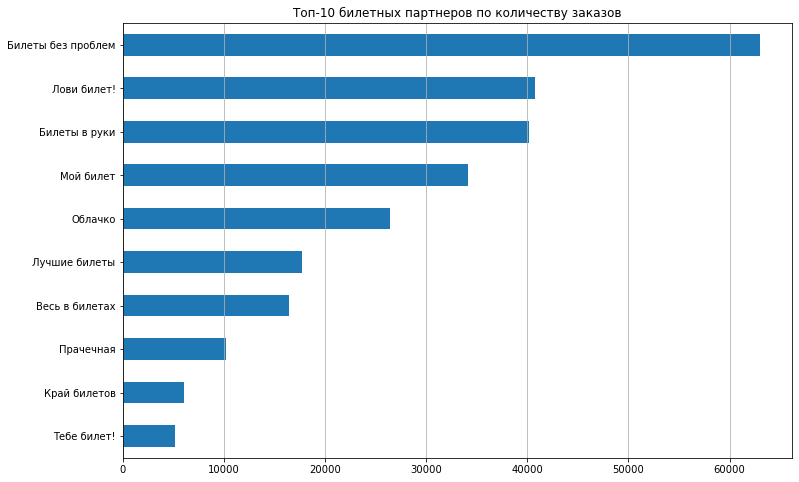

In [68]:
#Посмотрим также на общую статистику уникальных мероприятий по партнерам
orders_service = afisha_df.groupby('service_name')['order_id'].count()
display(orders_service.describe())

#Выведем линейчатую диаграмму с топом 10 партнеров по количеству заказов
top_10_orders_service = orders_service.sort_values(ascending=False).head(10)
top_10_orders_service = top_10_orders_service.sort_values()
top_10_orders_service.plot(kind='barh',
               title= 'Топ-10 билетных партнеров по количеству заказов',
               legend=False,
               ylabel='Количество заказов',
               xlabel='',
               rot=0,
               figsize=(12, 8))
plt.grid(axis='x')
plt.show()

По количеству заказов оператор "Билеты без проблем" опережает ближайших конкурентов "Лови билет!" и "Билеты в руки" в 1.5 раза. На его счету  63026 заказов. Разброс значений между операторами также большой, минимальное количество заказов - 4, среднее около 8 тыс. заказов, медиана 1348 шт.

count          36.00
mean      4140762.11
std       6868533.48
min            64.30
25%         68763.62
50%        938207.01
75%       4003295.10
max      24854263.36
Name: revenue_rub, dtype: object

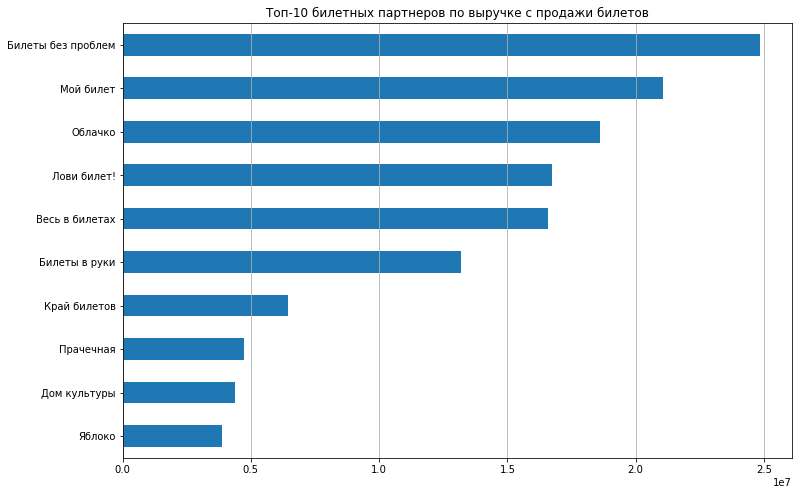

In [69]:
#Посмотрим на общую статистику выручки по партнерам
revenue_service = afisha_df.groupby('service_name')['revenue_rub'].sum()
display(revenue_service.describe().apply(lambda x: f'{x:.2f}'))

#Выведем линейчатую диаграмму с топом 10 партнеров по выручке
top_10_revenue_service = revenue_service.sort_values(ascending=False).head(10)
top_10_revenue_service = top_10_revenue_service.sort_values()
top_10_revenue_service.plot(kind='barh',
               title= 'Топ-10 билетных партнеров по выручке с продажи билетов',
               legend=False,
               ylabel='Выручка',
               xlabel='',
               rot=0,
               figsize=(12, 8))
plt.grid(axis='x')
plt.show()


По выручке с билетов оператор "Билеты без проблем" подтверждает свое лидерство: выручка от партнера ок. 25 млн. руб. На втором месте оператор "Мой билет". Также к лидерам, приносящим наибольшую выручку сервису можно отнести операторов "Облачко", "Лови билет!", "Весь в билетах" и "Билеты в руки". Выручка от партнераства с ними более 13 млн. руб. Другие партнеры приносят уже существенно меньший вклад.

Посмотрим на долевое сообношение основных показателей. Сортировку сделаем по наиболее важному показателю для бизнеса- выручке с продаж.

In [70]:
#Нормализуем данные
afisha_df_service_normalized = afisha_df_service.div(afisha_df_service.sum(axis=0), axis=1)
afisha_df_service_normalized.sort_values('revenue_rub', ascending=False).head(10)

,event_name,order_id,revenue_rub
service_name,,,
Билеты без проблем,0.158166,0.219142,0.166732
Мой билет,0.052065,0.118712,0.141292
Облачко,0.088981,0.091828,0.124838
Лови билет!,0.194475,0.141817,0.112221
Весь в билетах,0.034744,0.057152,0.111131
Билеты в руки,0.148066,0.139811,0.088581
Край билетов,0.011766,0.021272,0.043129
Прачечная,0.044137,0.035542,0.031843
Дом культуры,0.011665,0.015396,0.029520


Итак, несмотря на то, что "Лови билет!" охватывает больше всего мероприятий, этот парнер приносит сервису только 11% выручки и 14% заказов. Бесспортным лидером, приносящим наибольшую долю вуручки 17% является оператор "Билет без проблем". На оператора "Мой билет" приходится почти в 2 раза меньше заказов, чем на лидера, но по выручке он практически догнал его и его доля составляет - 14%.

 **Промежуточные выводы:**

- Среди представленных регионов явно выделяются 2 лидера Каменевский регион (30% от всех заказов) и Североярская область (15%). На их долю приходится почти половина всех заказов и это самые приоритетные регионы для сервиса. Половина регионов имеет на своем счету не более 810 заказов, в то время как на счету лидера почти 90 тыс. заказов.

- Среди партнеров сервиса, которых всего 36, также можно выделить явных лидеров, которые приносят сервису более 9% выручки каждый: "Билеты без проблем" (17% от общей выручки),"Мой билет", "Облачко", "Лови билет!", "Весь в билетах" и "Билеты в руки". Сотрудничество с ними будет приоритетным. 

- Обратим внимани на сервис "Лови билет!", который охватывает самое большое количество уникальных мероприятий, а значит довольно перспективен в будущем и может увеличить свой вклад в выручку сервиса. И также выделим оператора "Билеты в руки", который по охвату мероприятий практически сопоставим с лидером, а значит имеет большой потенциал и может увеличить приносимую выручку.

- Вклад в выручку с продажи билетов половины партнеров составляет менее 1 млн. руб. Среди них встречаются такие, которые принесли сервису всего 64 руб. за весь период. Сотрудничество с ними надо оценить, если партнерство требует определенных финансовых или временных затрат, то от сотрудничества с ними следует отказаться.

[*К содержанию*](#intro) 

<a id='4'></a>
## 4. Статистический анализ данных

Проверим гипотезы относительно активности пользователей мобильных и стационарных устройств, предполагающие большую активность пользователей мобильных устройств.

При проверке гипотез будем следовать следующему алгоритму:
- проверить данные на пропуски и дубликаты;
- проверка групп эксперимента на пересечение;
- проверка данных по заказам на аномалии и выбросы;
- проверка размеров выборок и их сбалансированости по размеру, статистики и распределение;
- расчет метрик по пользователям;
- проверка гипотезы с помощью подходящего теста.

Первая гипотеза, которую мы будем проверять звучит следующим образом: **"среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств"**.

Пусть пользователи мобильных приложений будут группой A, а стационарных компьютеров - группой B.

Первый шаг - проверка на пропуски и дубликаты  - была проведена во втором разделе.
Далее стоит проверить группы на пересечение.

In [71]:
#Проверим встречаются ли одновременно одни и те же пользователи в группах
users_mobile = afisha_autumn[afisha_autumn['device_type_canonical'] == 'mobile']['user_id']
users_desktop = afisha_autumn[afisha_autumn['device_type_canonical'] == 'desktop']['user_id']

intersection = list(set(users_mobile ) & set(users_desktop))
len(intersection)

3252

Мы получили довольно большое количество пользователей, которые одновременно пользуются и мобильными приложениями и компьютерами. Посчитаем процент этих пользовтаелей от общего количетва.

In [72]:
len(intersection)/afisha_autumn['user_id'].nunique()

0.20564057164537752

Таких пользователей около 20% - это очень большой объем, оставим эти записи, т.к. удаление таколго большого объема может исказить результаты.

In [73]:
#Осталяем данные без фильтрации по пересечениям
afisha_test = afisha_autumn

Оставим данные, которые необходимы для проверки гипотезы.

In [74]:
#Сгруппируем заказы по типу устройств и пользователям
test_orders = afisha_test.groupby(['device_type_canonical', 'user_id'])['order_id'].count().reset_index()

Далее проверим данные по заказам на аномалии и выбросы.

In [75]:
#Выведем статистические показатели по количеству заказов на пользователя
test_orders['order_id'].describe()

count    19066.000000
mean         8.844855
std         61.478763
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       4334.000000
Name: order_id, dtype: float64

Общее количество пользователей = 19066, среднее количество заказов 9, медиана 2, стандартное отклонение 61, а максимальное количество 4334. Такая статистика говорит о наличии выбросов.
Посмотрим на гистограмму распределения и диаграмму размаха.

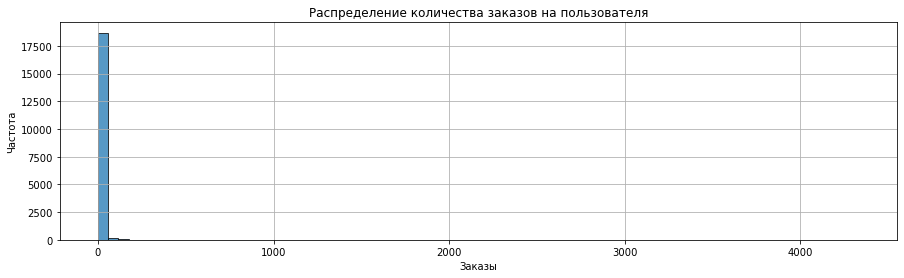

In [76]:
# Строим гистограмму распределения
plt.figure(figsize=(15, 4))
test_orders['order_id'].plot(
            kind='hist',
            bins=75, 
            alpha=0.75,
            edgecolor='black',
            rot=0, 
)

plt.title('Распределение количества заказов на пользователя')
plt.xlabel('Заказы')
plt.ylabel('Частота')
plt.grid()
plt.show()

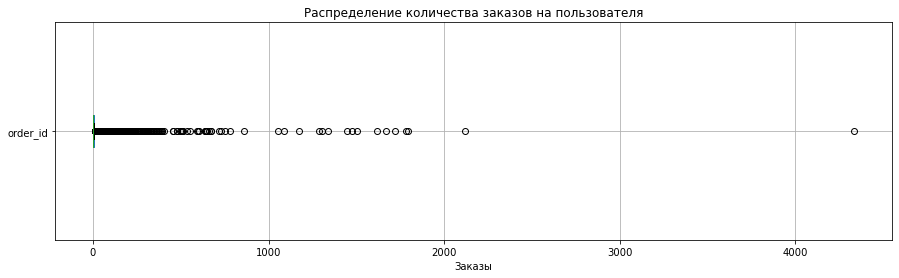

In [77]:
# Строим диаграмму размаха
plt.figure(figsize=(15, 4))
test_orders.boxplot(column='order_id', vert=False)
plt.title('Распределение количества заказов на пользователя')
plt.xlabel('Заказы')
plt.show()

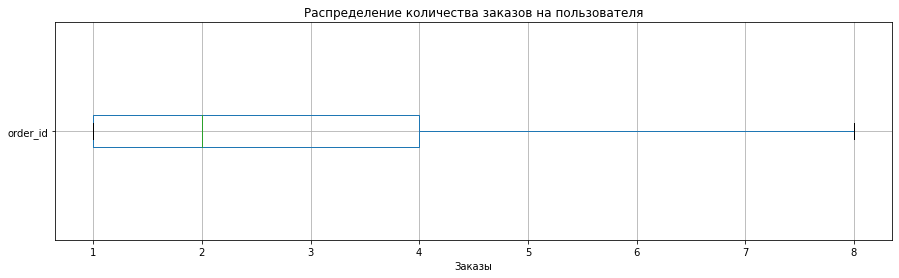

In [78]:
# Строим диаграмму размаха без выбросов
plt.figure(figsize=(15, 4))
test_orders.boxplot(column='order_id', vert=False, showfliers=False)
plt.title('Распределение количества заказов на пользователя')
plt.xlabel('Заказы')
plt.show()

Гистограмма распределения имеет тяжелый правый хвост, а диаграмма размаха показывает наличие выбросов. Типичное количество заказов находится в диапозоне от 1 до 8. Совершение более 4000 заказов за 5 месяцев скорее аномально и вероятно связано с наличием пользователей, которые делают огромное количество заказов в день с разных устройсчтв и на мероприятия в разных городах. Такие пользователи могут сильно исказить результаты статистического анализа. Для того, чтобы снизить влияние выбросов на результаты тестирования, ограничим данные для проверки гипотезы 95-м процентилем.

In [79]:
#Для вычислений используем метод quantile() и отфильтруем значения
test_orders = test_orders[(test_orders['order_id'] <= test_orders['order_id'].quantile(0.95))]

Теперь проверим размеры выборок, их статистики и распределение по отдельности.

In [80]:
#Посчитаем размеры выборок
test_orders_count = test_orders['device_type_canonical'].value_counts()
test_orders_count

mobile     13471
desktop     4665
Name: device_type_canonical, dtype: int64

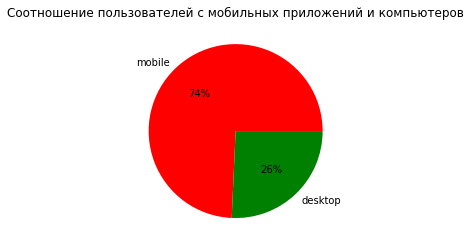

In [81]:
#Визуализируем результат
test_orders_count.plot(
    kind='pie',
    title='Соотношение пользователей с мобильных приложений и компьютеров',
    autopct='%.0f%%',
    ylabel='',
    colors=['red', 'green']
)

plt.show()

In [82]:
#Проверим статистику выбороки с пользователями мобильного приложения
test_orders_mobile = test_orders[(test_orders['device_type_canonical'] == 'mobile')].copy()
test_orders_mobile['order_id'].describe()

count    13471.000000
mean         3.389578
std          3.960697
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         23.000000
Name: order_id, dtype: float64

In [83]:
#Проверим статистику выбороки с пользователями, использующими компьютер
test_orders_desktop = test_orders[(test_orders['device_type_canonical'] == 'desktop')].copy()
test_orders_desktop['order_id'].describe()

count    4665.000000
mean        3.033869
std         3.519690
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        23.000000
Name: order_id, dtype: float64

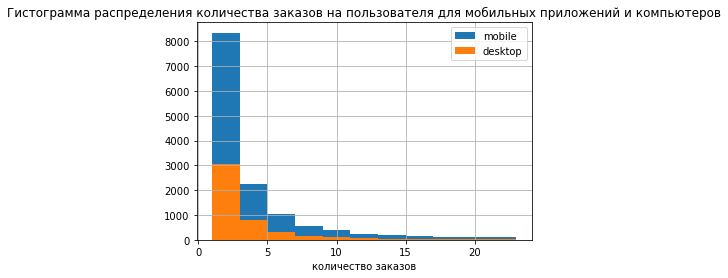

In [84]:
#Посмотрим на распределения выборок
test_orders_mobile['order_id'].hist(bins=11,label='mobile')
test_orders_desktop['order_id'].hist(bins=11,label='desktop')     

plt.title('Гистограмма распределения количества заказов на пользователя для мобильных приложений и компьютеров')
plt.xlabel('количество заказов')
plt.legend()
plt.show()

Распределения выборок схожи, стандартное отклонение имеет небольшое различие, но размеры выборок не сбалансированы по размеру, из-за это  среднее значение метрик может быть смещено, а результаты теста искажены.

Для сравнения выборочных средних двух выброк используют t-тесты. Для проверки нашей гипотезы будем использовать более гибкий Тест Уэлча, который корректирует количество степеней свободы с учётом дисперсий и размеров выборок и является более надёжным для работы с неоднородными данными.

In [85]:
mean_orders_mobile = round(test_orders_mobile['order_id'].mean(), 1)
mean_orders_desktop = round(test_orders_desktop['order_id'].mean(), 1)

print(f'Средннее количество заказов на пользователя для мобильных устройств - {mean_orders_mobile}, для стационарных устройств - {mean_orders_desktop}')

Средннее количество заказов на пользователя для мобильных устройств - 3.4, для стационарных устройств - 3.0


In [87]:
metric_a = test_orders_mobile['order_id'] ## выборка для целевой метрики для мобильных устройст (группа А)
metric_b = test_orders_desktop['order_id'] ## выборка для целевой метрики для стационарных устройств (группа В)

alpha = 0.05 ## задаем стандартный уровень значимости при проверке гипотезы о равенстве выборочных средних

## применяем t-тест Уэлча
stat_welch_ttest, p_value_welch_ttest = ttest_ind(
    metric_a, 
    metric_b, 
    equal_var=False,
    alternative='greater' ## поскольку альтернативная гипотеза о том, что выборочное среднее для мобильных устройст больше
) 

if p_value_welch_ttest>alpha:
    print(f'p-value теста Уэлча ={round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группах для мобильных не выше, чем для стационарных.')
    print('Среднее количество заказов на одного пользователя для мобильных устройств не имеет статистически значимого превышения.')
else:
    print(f'p-value теста Уэлча ={round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочное среднее в группе мобильных устройств выше.')
    print('Среднее количество заказов на одного пользователя для мобильных устройств больше, и это различие статистически значимо.')

p-value теста Уэлча =0.0
Нулевая гипотеза не находит подтверждения! Выборочное среднее в группе мобильных устройств выше.
Среднее количество заказов на одного пользователя для мобильных устройств больше, и это различие статистически значимо.


Результаты теста позволяют нам считать, что пользователи мобильных устройств действительно делают больше заказов, чем пользоватеи стационарных устройств. 

Теперь проверим вторую гипотезу: **Среднее время между заказами пользователей мобильных приложений выше по сравнению с
пользователями стационарных устройств**.

Так как в столбце 'days_since_prev', содержащем данные по количеству дней с предыдущей покупки для каждого пользователя, есть пропуски, означающие, что пользователь делает заказ впервые, мы должны отфильтровать таблицу по ним. Для обозначения таких строк, мы использовали индикатор "-1". 

In [88]:
#Отфильтруем таблицу по индикаторам
test_days = afisha_autumn[(afisha_autumn['days_since_prev'] >= 0)]

In [89]:
#Выведем статистические показатели по количетсву дней с предыдущей покупки
test_days['days_since_prev'].describe()

count    160287.000000
mean          3.625528
std          13.138485
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         148.000000
Name: days_since_prev, dtype: float64

Общее количестов подходящих нам записей 160287. Среднее значение более 3,6 дней, стандартное отклонение более 13, медиана равно 0, минимлаьно значение 0, максимальное - 148 дней. 
Получается, что большинство заказов было оформлено в тот же день, когда совершена предыдущая покупка.  Посмотрим на гистограмму распределения.

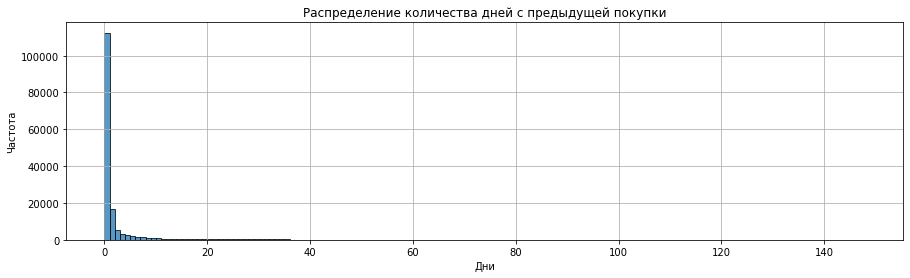

In [90]:
# Строим гистограмму распределения
plt.figure(figsize=(15, 4))
test_days['days_since_prev'].plot(
            kind='hist',
            bins=148, 
            alpha=0.75,
            edgecolor='black',
            rot=0, 
)

plt.title('Распределение количества дней с предыдущей покупки')
plt.xlabel('Дни')
plt.ylabel('Частота')
plt.grid()
plt.show()

Несмотря на неравномерное распределение данных, говорить о выбросах мы не можем, так как максимальное значение 148 дней вполне реалистично. Однако огромное количество заказов, совершенных в тот же день (больше половины)  скорее говорит об аномальном пользовательском поведении. Скорее всего на такое поведение пользователи, которые скупали билеты в большом количестве на разные мероприятия в течение дня. Такое поведение может исказить результаты теста. Посмотрим на количество заказов, совершенных пользователями за день.

In [91]:
test_days.groupby(['user_id', 'created_dt_msk'])['order_id'].count().sort_values(ascending=False).head(15)

user_id          created_dt_msk
cdbc02c6ad8087a  2024-10-01        242
8d6c1ff89fac35f  2024-10-31        238
0beb8fc0c0a9ce1  2024-09-03        183
cdbc02c6ad8087a  2024-09-03        169
0beb8fc0c0a9ce1  2024-10-01        163
fe237d2cfd6e503  2024-10-31        161
0beb8fc0c0a9ce1  2024-10-15        160
                 2024-10-25        159
                 2024-10-18        149
                 2024-10-26        139
                 2024-10-03        139
                 2024-10-24        138
4226e240b0f7a38  2024-09-03        137
0beb8fc0c0a9ce1  2024-10-28        137
18e9aead0a393e7  2024-10-01        130
Name: order_id, dtype: int64

Мы видим, что пользователей, совершивших, большое количество покупок в течение дня достаточно много, скорее всего в этом и заключается причина того, что больше половины заказов из наших данных совершены в день предыдущей покупки.

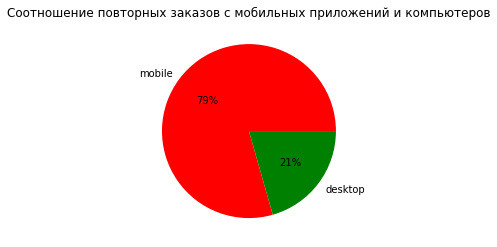

In [92]:
#Визуализируем размеры выборок: количество заказов в разбивке по типам устройств.
test_days['device_type_canonical'].value_counts().plot(
    kind='pie',
    title='Соотношение повторных заказов с мобильных приложений и компьютеров',
    autopct='%.0f%%',
    ylabel='',
    colors=['red', 'green']
)

plt.show()

In [93]:
#Проверим статистику выбороки с пользователями мобильных устройств
test_days_mobile = test_days[(test_days['device_type_canonical'] == 'mobile')].copy()
test_days_mobile['days_since_prev'].describe()

count    127300.000000
mean          3.780943
std          13.391139
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         148.000000
Name: days_since_prev, dtype: float64

In [94]:
#Проверим статистику выбороки с пользователями стационарных устройств
test_days_desktop = test_days[(test_days['device_type_canonical'] == 'desktop')].copy()
test_days_desktop['days_since_prev'].describe()

count    32987.000000
mean         3.025768
std         12.095647
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        146.000000
Name: days_since_prev, dtype: float64

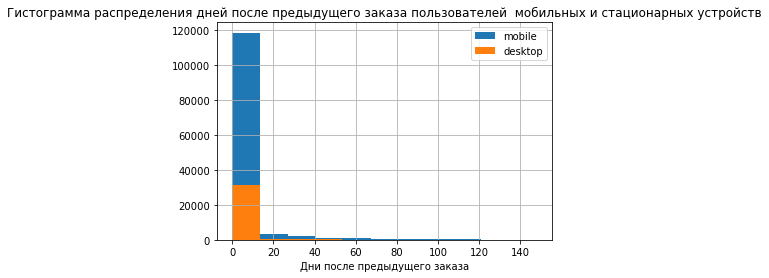

In [95]:
#Посмотрим на распределения выборок
test_days_mobile['days_since_prev'].hist(bins=11,label='mobile')
test_days_desktop['days_since_prev'].hist(bins=11,label='desktop')     

plt.title('Гистограмма распределения дней после предыдущего заказа пользователей  мобильных и стационарных устройств')
plt.xlabel('Дни после предыдущего заказа')
plt.legend()
plt.show()

Статистика по основным параметрам схожа. Однако,  разница в размерах выборок  довольно большая, что может еще сильнее исказить результаты теста.

Для проверки гипотезы будем также как и в предыдущем случае использовать Тест Уэлча, который является более надёжным для работы с неоднородными данными.

Сформулируем гипотезы для проведения теста.

Нулевая гипотеза H₀: 𝜇mobile <= 𝜇desktop **Среднее время между заказами пользователей мобильных приложений не выше, чем для стационарных.**

Альтернативная гипотеза H₁: 𝜇mobile > 𝜇desktop **Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств**.

Рассчитаем интересующие нас метрики.

In [96]:
mean_days_mobile = round(test_days_mobile['days_since_prev'].mean(), 1)
mean_days_desktop = round(test_days_desktop['days_since_prev'].mean(), 1)

print(f'Средннее количество дней после предыдущего заказа для мобильных устройств - {mean_days_mobile}, для стационарных устройств - {mean_days_desktop}')

Средннее количество дней после предыдущего заказа для мобильных устройств - 3.8, для стационарных устройств - 3.0


In [97]:
metric_ad = test_days_mobile['days_since_prev'] ## выборка для целевой метрики для мобильных устройст (группа А)
metric_bd = test_days_desktop['days_since_prev'] ## выборка для целевой метрики для стационарных устройств (группа В)

alpha = 0.05 ## задаем стандартный уровень значимости при проверке гипотезы о равенстве выборочных средних

## применяем t-тест Уэлча
stat_welch_ttest, p_value_welch_ttest = ttest_ind(
    metric_ad, 
    metric_bd, 
    equal_var=False,
    alternative='greater' ## поскольку альтернативная гипотеза о том, что выборочное среднее для мобильных устройст больше
) 

if p_value_welch_ttest>alpha:
    print(f'p-value теста Уэлча ={round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группе А не выше, чем в группе В.')
    print('Среднее количество дней между заказами для мобильных устройств не выше. чем для стационарных.')
else:
    print(f'p-value теста Уэлча ={round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочное среднее в группе мобильных устройств выше.')
    print('Среднее количество дней после предыдущего заказа для мобильных устройств больше, и это различие статистически значимо.')

p-value теста Уэлча =0.0
Нулевая гипотеза не находит подтверждения! Выборочное среднее в группе мобильных устройств выше.
Среднее количество дней после предыдущего заказа для мобильных устройств больше, и это различие статистически значимо.


Результаты теста подтвердили гипотезу, что среднее количество дней с предыдущего заказа среди пользователей мобильных устройств выше. Однако в данных было слишком много условий, которые могли исказить результаты, в том числе наличие пользователей, которые делали множество заказов течение одного дня. Попробуем провести этот же тест, отфильтровав записи, совершенные в один день одними и тем же пользователями, проделав те же самые шаги.

In [98]:
#Отфильтруем таблицу по ненулевым значениям
test_days_0 = afisha_autumn[(afisha_autumn['days_since_prev'] > 0)]
#Выведем статистические показатели по количетсву дней с предыдущей покупки
test_days_0['days_since_prev'].describe()

count    47822.000000
mean        12.151834
std         21.793876
min          1.000000
25%          1.000000
50%          3.000000
75%         11.000000
max        148.000000
Name: days_since_prev, dtype: float64

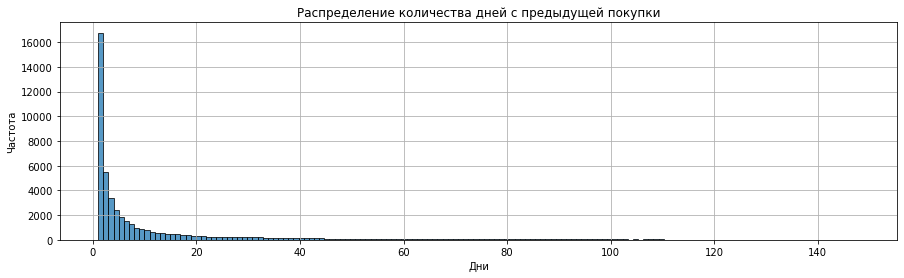

In [99]:
# Строим гистограмму распределения
plt.figure(figsize=(15, 4))
test_days_0['days_since_prev'].plot(
            kind='hist',
            bins=148, 
            alpha=0.75,
            edgecolor='black',
            rot=0, 
)

plt.title('Распределение количества дней с предыдущей покупки')
plt.xlabel('Дни')
plt.ylabel('Частота')
plt.grid()
plt.show()

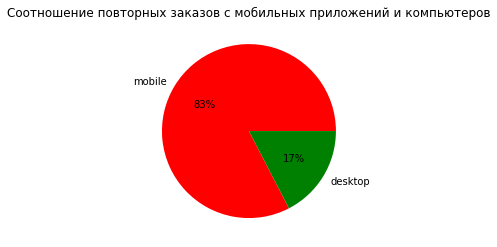

In [100]:
#Визуализируем размеры выборок: количество заказов в разбивке по типам устройств.
test_days_0['device_type_canonical'].value_counts().plot(
    kind='pie',
    title='Соотношение повторных заказов с мобильных приложений и компьютеров',
    autopct='%.0f%%',
    ylabel='',
    colors=['red', 'green']
)

plt.show()

In [101]:
#Проверим статистику выбороки с пользователями мобильных устройств
test_days_mobile_0 = test_days_0[(test_days_0['device_type_canonical'] == 'mobile')].copy()
test_days_mobile_0['days_since_prev'].describe()

count    39506.000000
mean        12.183314
std         21.805255
min          1.000000
25%          1.000000
50%          3.000000
75%         11.000000
max        148.000000
Name: days_since_prev, dtype: float64

In [102]:
#Проверим статистику выбороки с пользователями стационарных устройств
test_days_desktop_0 = test_days_0[(test_days_0['device_type_canonical'] == 'desktop')].copy()
test_days_desktop_0['days_since_prev'].describe()

count    8316.000000
mean       12.002285
std        21.740422
min         1.000000
25%         1.000000
50%         3.000000
75%        11.000000
max       146.000000
Name: days_since_prev, dtype: float64

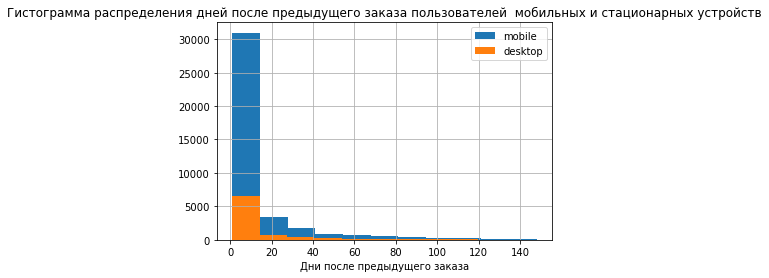

In [103]:
#Посмотрим на распределения выборок
test_days_mobile_0['days_since_prev'].hist(bins=11,label='mobile')
test_days_desktop_0['days_since_prev'].hist(bins=11,label='desktop')     

plt.title('Гистограмма распределения дней после предыдущего заказа пользователей  мобильных и стационарных устройств')
plt.xlabel('Дни после предыдущего заказа')
plt.legend()
plt.show()

Количество записей сократилось в несколько раз, однако данные стали более реалистичными.

In [104]:
mean_days_mobile_0 = round(test_days_mobile_0['days_since_prev'].mean(), 1)
mean_days_desktop_0 = round(test_days_desktop_0['days_since_prev'].mean(), 1)

print(f'Средннее количество дней после предыдущего заказа для мобильных устройств - {mean_days_mobile_0}, для стационарных устройств - {mean_days_desktop_0}')

Средннее количество дней после предыдущего заказа для мобильных устройств - 12.2, для стационарных устройств - 12.0


In [105]:
metric_ad_0 = test_days_mobile_0['days_since_prev'] ## выборка для целевой метрики для мобильных устройст (группа А)
metric_bd_0 = test_days_desktop_0['days_since_prev'] ## выборка для целевой метрики для стационарных устройств (группа В)

alpha = 0.05 ## задаем стандартный уровень значимости при проверке гипотезы о равенстве выборочных средних

## применяем t-тест Уэлча
stat_welch_ttest, p_value_welch_ttest = ttest_ind(
    metric_ad_0, 
    metric_bd_0, 
    equal_var=False,
    alternative='greater' ## поскольку альтернативная гипотеза о том, что выборочное среднее для мобильных устройст больше
) 

if p_value_welch_ttest>alpha:
    print(f'p-value теста Уэлча ={round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группе А не выше, чем в группе В.')
    print('Среднее количество дней между заказами среди пользователей мобильных устройств не выше, чем среди пользователей стационарных.')
else:
    print(f'p-value теста Уэлча ={round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочное среднее в группе мобильных устройств выше.')
    print('Среднее количество дней после предыдущего заказа для мобильных устройств больше, и это различие статистически значимо.')

p-value теста Уэлча =0.25
Нулевая гипотеза находит подтверждение! Выборочные средние в группе А не выше, чем в группе В.
Среднее количество дней между заказами среди пользователей мобильных устройств не выше, чем среди пользователей стационарных.


Результат, полученный после фильтрации заказов, оформленных в один и тот же день, которые вызывают очень много вопросов, отличается от результатов, полученных на полной выборке. Хотя среднее количество количество дней между совершением заказов по-прежнему выше в группе мобильных устройств, это превышение теряет свою статистическую значимость после фильтрации данных.

**Промежуточный вывод**

Мы провели статстическую проверку двух гипотез относительно активностиипользователей мобильных и стационарных устройств.
Для проверки обеих гипотез был использован t-тест Уэлча.

Проведенный статичтический анализ дал нам аналитические основания утверждать, что среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств

Однако, мы не смогли подвердить гипотезу  о том, что превышение среднего времени между заказами пользователей мобильных приложений по сравнению с пользователями стационарных устройств имеет статистическую значимость, так как исходные данные имели аномальные значения и неравномерное распределения, а после фильтрации данных альтернативная гипотеза не подтвердилась.


[*К содержанию*](#intro) 

<a id='5'></a>
## 5. Общий вывод и рекомендации

В проекте анализировались данные сервиса Яндекс Афиша с 1 июня  по 31 октября 2024г.
Были проведены предобработка представленных данных, исследовательский анализ, а также статистическая проверка двух предложенных гипотез об активности пользователей разных типов устройств осенью.

**Выводы:**


1. Рост продаж наблюдается на протяжении всего анализируемого периода, осенью он гораздо более выраженный. Рост характерен для всех категорий в разрезе типа устройств, с которых осуществляется покупка, типа мероприятий, а также возрастных рейтингов, но темпы роста в разных категориях различаются.
2. Наиболее активный рост продаж осенью характерен для спортивных мероприятий (рост с 2,5% до 11,1%) и ёлок (рост с 0,2% до 1%), немного увеличивается доля продаж билетов в театры. По остальным событиям доли продаж сокращаются (выставки и концерты -6% в удельном весе), самое заметное сокращение доли продаж у категории другое (с 27% до 20%).
3. Осенью увеличивается доля детских (0-12) и снижается доля "взрослых" (16-18) мероприятий. Наибольший рост в категории 0+ на 6%, наибольшее сокращение в категории 18+ на 5%.
4. Осенью средняя выручка с 1 билета для разных типов мероприятий изменилась: для категорий спорт и другое незначительно сократилась, увеличилась на 6% на выставки и стендапы, сократилась на концерты, ёлки и театры на 11%, 15% и 18% соответственно.
5. Осенью можно проследить тенденцию к увеличению ежедневного количества заказов и уникальных пользователей. Это хорошая тенденция для бизнеса.
6. Наблюдаются аномальные всплески по количеству заказов на 1 клиента и средней выручки с билета 3 сентября и 1 октября. Несколько пользователей скупают билеты с низкой стоимостью в большом количестве с разных устройств, на разные мероприятия в разных городах. Возможно это перекупщики, либо сбой в записи данных. Этот вопрос требует дополнительного изучения.
7. Наибольшая активность пользователей наблюдается в будние дни, в выходные и понедельник - минимальная.
8. Каменевский регион (30% от всех заказов) и Североярская область (15%) являются явными лидерами по количеству заказов и разнообразию мероприятий. Половина регионов имеет на своем счету не более 810 заказов и 68 различных мероприятий, в то время как на счету лидера почти 90 тыс. заказов и ок. 5тыс. различных событий.
9. Среди партнеров сервиса, которых всего 36, также можно выделить явных лидеров, которые приносят сервису более 9% выручки каждый: "Билеты без проблем" (лидер: выручка 25 млн. руб., 17% среди других партнеров),"Мой билет", "Облачко", "Лови билет!", "Весь в билетах" и "Билеты в руки". Сотрудничество с ними будет приоритетным.
10. Сервисы "Лови билет!" и "Билеты в руки" можно рассматривать как перспективных для развития сотрудничества, т.к. они охватывают большее количество уникальных мероприятий, чем их ближайшие конкуренты по выручке и заказам.
11. По результатам статичтического анализа гипотез относительно активности пользователей мобильных и стационарных устройств можно говорить о том, что превышение среднего количества заказов на одного пользователя мобильных устройств по сравнению с пользователями компьютеров действительно имеет статистическую значимость.
12. Гипотеза о том, что среднее время между заказами пользователей мобильных устройств выше по сравнению с пользователями стационарных компьтеров, не нашла подтверждение, так как исходные данные имели аномальные значения и неравномерное распределение, и после фильтрации данных результаты статистического теста изменились.

**Рекомендации:**
1. При подготовке к предновогоднему периоду распродаж и акций, стоит обратить особое внимание на такие мероприятия, как ёлки, спектакли и спортивные мероприятия, так как интерес аудитории к ним вырос. Особое внимание - на события для аудитории 0-12 лет.
2. Стоит разобраться с аномальными всплесками заказов 3 сентября и 1 октября, пользователи, делающие огромное количество заказов в течение нескольких часов по низким ценам, могут снижать выручку сервиса.
3. Запуск промоакций лучше проводить в будни, начиная со вторника по четверг, т.к. в выходные активность пользователей снижается.
4. Особый акцент в проведении рекламных мероприятий делаем на регионах: Каменевский регион и Североярская область, они приносят сервису почти 50% выручки.
5. Среди партнеров особое внимание уделяем сервисам: "Билеты без проблем","Мой билет", "Облачко", "Лови билет!", "Весь в билетах", "Билеты в руки", они приносят наибольший доход. Особое внимание стоит уделить  сервисам  "Лови билет!" и "Билеты в руки", так как в перспективе при их продвижении, они могут давать компании еще больше выручки.
6. Среди парнеров Яндекс Афиши есть сервисы, через которые осуществляется крайне малое количестов заказов, если они требуют каких-либо затрат, от них стоит отказаться.
7. Пользователи мобильных устройств более активны, значит продвижение мобильного приложения более перспективно. 

[*К содержанию*](#intro) 

Ссылка на аналитический дашборд в Yandex DataLens, отражающий динамику ключевых бизнес-показателей, популярность мероприятий и структуру выручки в разрезе категорий событий и устройств (дополнительное задание к проекту).
https://datalens.yandex/do85rn8iv286z